# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 05.10.2023

Мягкий дедлайн: 23:59MSK 18.10.2023

Жесткий дедлайн: 23:59MSK 22.10.2022

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [1]:
!pip install folium

In [2]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

%matplotlib inline

sns.set(style="darkgrid")

np.random.seed(0)

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [4]:
!pip install gdown
!gdown "https://drive.google.com/uc?id=1lcqROt6b-jH7DFJIhw9X3OW1L-6pKr3P"

Downloading...
From: https://drive.google.com/uc?id=1lcqROt6b-jH7DFJIhw9X3OW1L-6pKr3P
To: /content/train.csv
100% 201M/201M [00:05<00:00, 37.2MB/s]


In [5]:
data = pd.read_csv("train.csv")
data.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [6]:
data.drop(columns='dropoff_datetime', inplace=True)
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   passenger_count     1458644 non-null  int64         
 4   pickup_longitude    1458644 non-null  float64       
 5   pickup_latitude     1458644 non-null  float64       
 6   dropoff_longitude   1458644 non-null  float64       
 7   dropoff_latitude    1458644 non-null  float64       
 8   store_and_fwd_flag  1458644 non-null  object        
 9   trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 111.3+ MB


В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

**Перед тем как строить само распределение, посмотрим как выглядят эти самые trip_duration**

In [7]:
data_groups = data.groupby(data['trip_duration']).size().reset_index()
data_groups.rename(columns={'trip_duration': 'Duration', 0: 'Count'}, inplace=True)
data_groups

Duration  Count
0            1     33
1            2    177
2            3    318
3            4    317
4            5    284
...        ...    ...
7412     86392      1
7413   1939736      1
7414   2049578      1
7415   2227612      1
7416   3526282      1

[7417 rows x 2 columns]

**В конце есть 4 явных выброса. Так как построив график вместе с ними мы точно не получим ничего нормального, выкинем их из построения**

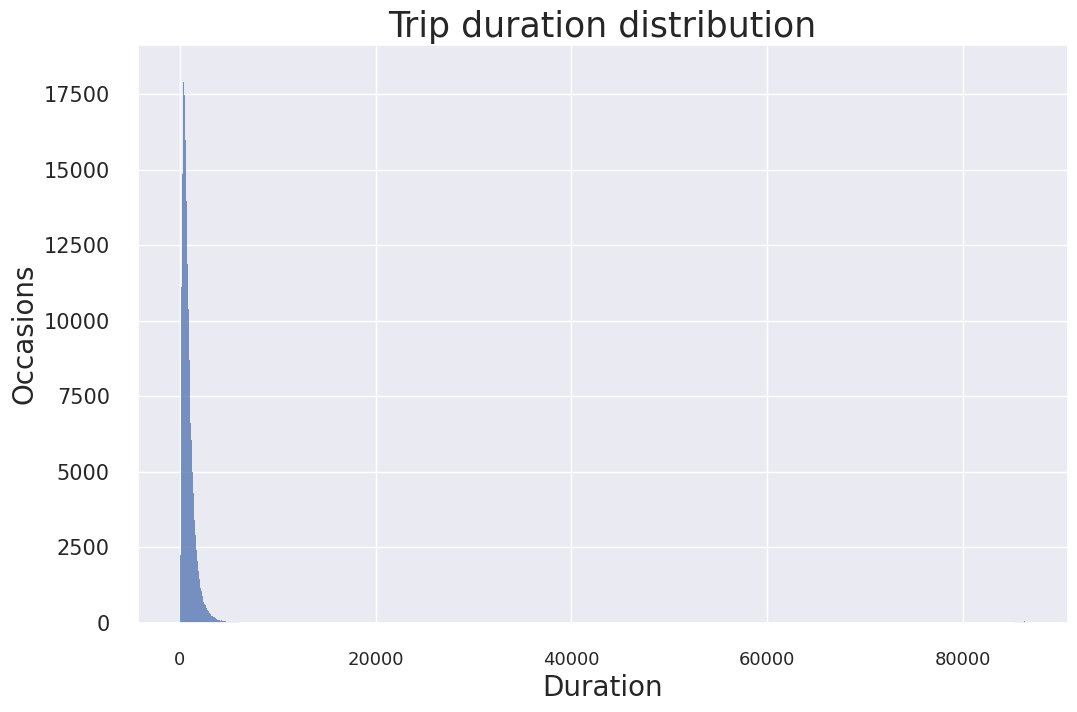

In [8]:
fig = plt.figure(figsize=(12, 7.5))
ax = fig.add_subplot(111)
sns.histplot(data[data['trip_duration'] <= 86392]['trip_duration'])
ax.set_title("Trip duration distribution", fontsize=25)
ax.set_xlabel("Duration", fontsize=20)
ax.set_ylabel("Occasions", fontsize=20)
ax.tick_params(axis='y',
               which='major',
               direction='inout',
               length=10,
               width=1.5,
               pad=15,
               labelsize=15
               )
ax.tick_params(axis='x',
               which='major',
               direction='inout',
               length=10,
               width=1.5,
               pad=15,
               labelsize=13
               )
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

**Ответ: По резкому росту и остаточному длинному хвосту (его почти не видно на графике из за малых значений) это похоже на логнормальное распределение.**

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

**Ответ: $RMSLE$ примерно говорит что предсказание $y_i = 1.01$ при $\alpha(x_i) = 1$ так же плохо, как предсказание $y_i = 1001$ при $\alpha(x_i) = 1000$. При $RMSE$ же ошибка $y_i = 1001$ при $\alpha(x_i) = 1000$ будет равноценна $y_i = 2$ при $\alpha(x_i) = 1$. Так как у нас довольно большой разброс trip_duration (от 1 до ~80000, не считая нескольких выбросов, которые скорее всего являются некорректными данными), то логичнее использовать $RMSLE$, которое будет строже наказывать за ошибки на малых значениях.**

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство:
Пользуемся тем, что $\hat{y}_i = \log{(y_i + 1)} \Rightarrow y_i = e^{\hat{y}_i}-1,\ a(x_i) = \exp(\hat{a}(x_i)) - 1$<br>
Тогда
$$
\text{RMSLE}(X, y, a) =
\sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2} =
\sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(e^{\hat{y}_i}-1 + 1)} - \log{(e^{\hat{a}(x_i)} - 1 + 1)}\big)^2} =
\sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y}_i - \hat{a}(x_i)\big)^2} =
\text{RMSE}(X, \hat{y}, \hat{a})
$$
Как мы знаем, RMSE отличает от MSE только наличие корня:
$$
\text{RMSE}(X, \hat{y}, \hat{a}) = \sqrt{\text{MSE}(X, \hat{y}, \hat{a})}
$$
То есть:
$$
\text{RMSLE}(X, y, a) = \sqrt{\text{MSE}(X, \hat{y}, \hat{a})}
$$
Получили в итоге то, что и требовалось.<br><br>**
Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

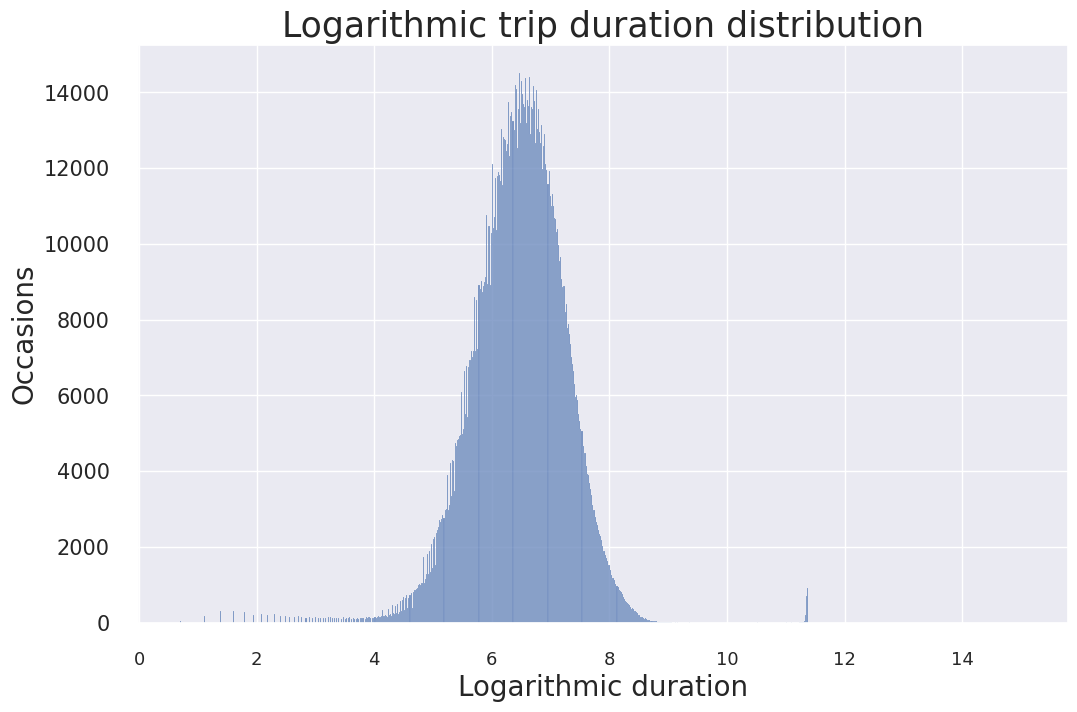

In [9]:
data['log_trip_duration'] = np.log1p(data['trip_duration'])
# Далее по заданиям снова потребуется эта колонка, поэтому пока оставим ее

fig = plt.figure(figsize=(12, 7.5))
ax = fig.add_subplot(111)
sns.histplot(data['log_trip_duration'])
ax.set_title("Logarithmic trip duration distribution", fontsize=25)
ax.set_xlabel("Logarithmic duration", fontsize=20)
ax.set_ylabel("Occasions", fontsize=20)
ax.tick_params(axis='y',
               which='major',
               direction='inout',
               length=10,
               width=1.5,
               pad=15,
               labelsize=15
               )
ax.tick_params(axis='x',
               which='major',
               direction='inout',
               length=10,
               width=1.5,
               pad=15,
               labelsize=13
               )
plt.show()

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [10]:
def rmsle(log1p_y_true, log1p_y_pred):
    error = (np.sum((log1p_y_pred - log1p_y_true) ** 2) / len(log1p_y_true)) ** 0.5
    return error


best_const = np.exp(np.sum(data['log_trip_duration']) / len(data['log_trip_duration']))
print("Best const value:", best_const)

prediction = np.empty(len(data['log_trip_duration']))
prediction.fill(np.log1p(best_const))
rmsle_best_const = rmsle(data['log_trip_duration'], prediction)
print("RMSLE const error:", rmsle_best_const)

assert np.allclose(rmsle_best_const, 0.79575, 1e-4)

Best const value: 643.5362830079474
RMSLE const error: 0.7957607513833939


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

**Позже эти признаки все равно попросят добавить, а так ими удобнее пользоваться по ходу заданий.**

In [11]:
data['hour'] = data['pickup_datetime'].dt.hour
data['weekday'] = data['pickup_datetime'].dt.day_name()
data['month'] = data['pickup_datetime'].dt.month_name()

In [12]:
data_groups = data.groupby(data['pickup_datetime'].dt.date).size().reset_index()
data_groups.rename(columns={'pickup_datetime': 'date', 0: 'count'}, inplace=True)
data_groups

date  count
0    2016-01-01   7162
1    2016-01-02   6512
2    2016-01-03   6353
3    2016-01-04   6725
4    2016-01-05   7204
..          ...    ...
177  2016-06-26   7084
178  2016-06-27   7311
179  2016-06-28   7253
180  2016-06-29   7623
181  2016-06-30   7588

[182 rows x 2 columns]

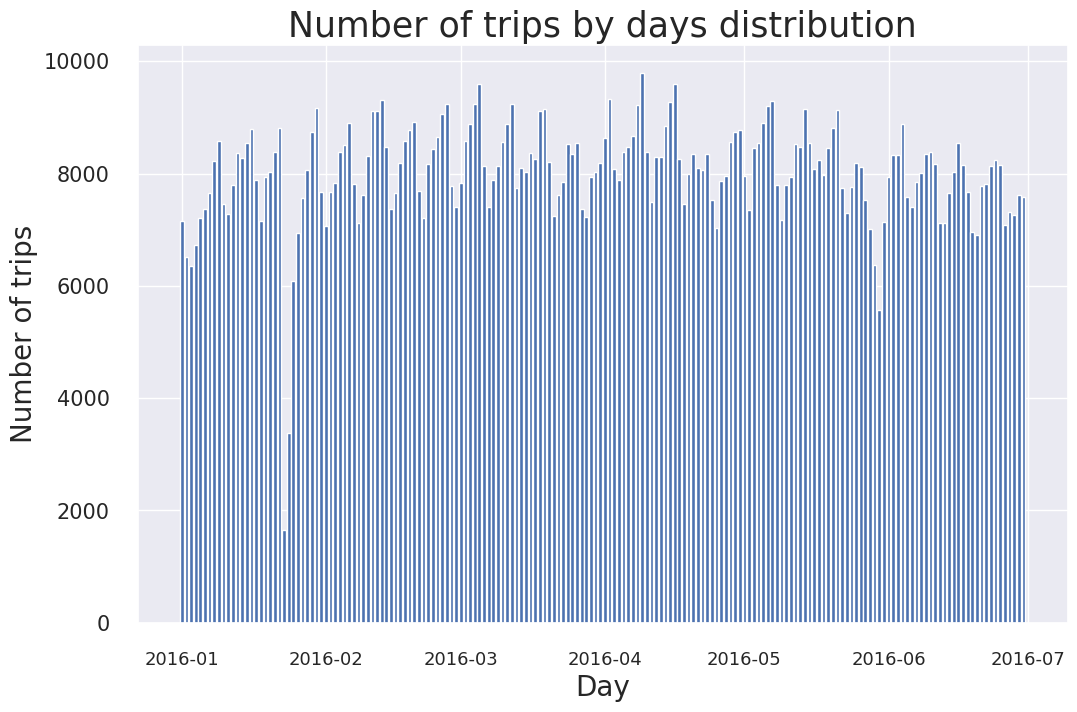

In [13]:
fig = plt.figure(figsize=(12, 7.5))
ax = fig.add_subplot(111)
plt.bar(data_groups['date'], data_groups['count'])
ax.set_title("Number of trips by days distribution", fontsize=25)
ax.set_xlabel("Day", fontsize=20)
ax.set_ylabel("Number of trips", fontsize=20)
ax.tick_params(axis='y',
               which='major',
               direction='inout',
               length=10,
               width=1.5,
               pad=15,
               labelsize=15
               )
ax.tick_params(axis='x',
               which='major',
               direction='inout',
               length=10,
               width=1.5,
               pad=15,
               labelsize=13
               )
plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

In [14]:
data_groups[data_groups['count'] < 4000]

date  count
22  2016-01-23   1648
23  2016-01-24   3383

**Пишут, что власти запретили автомобильное движение в Нью-Йорке из-за снежной бури.**

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [15]:
data_groups = data.groupby(data['weekday']).size().reset_index()
data_groups.rename(columns={0: 'count'}, inplace=True)

weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
data_groups['weekday'] = pd.Categorical(data_groups['weekday'], categories=weekdays)
data_groups = data_groups.sort_values('weekday')
data_groups

weekday   count
1     Monday  187418
5    Tuesday  202749
6  Wednesday  210136
4   Thursday  218574
0     Friday  223533
2   Saturday  220868
3     Sunday  195366

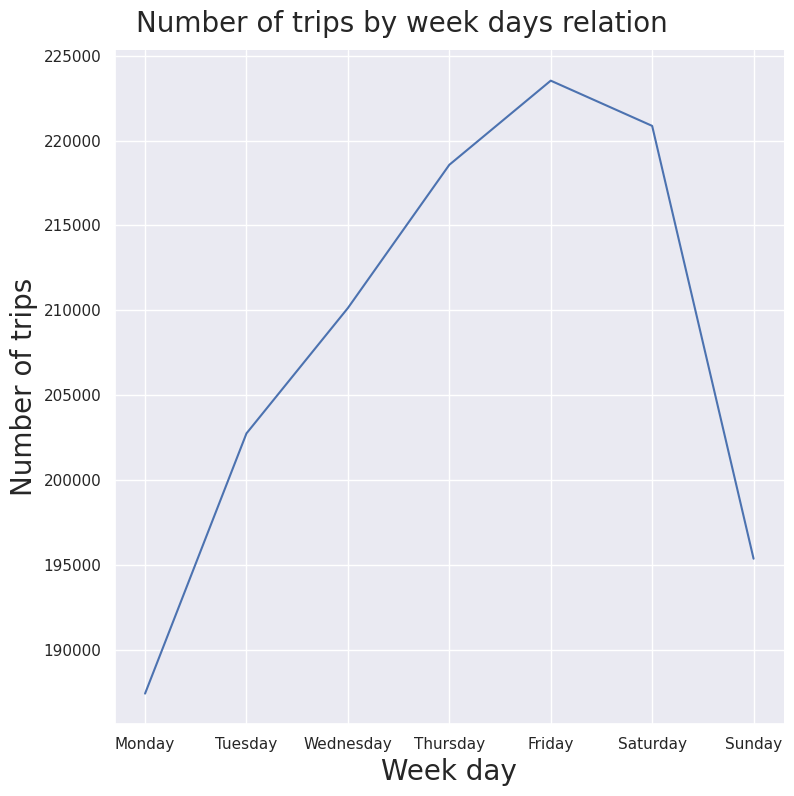

In [16]:
relation = sns.relplot(data=data_groups, x='weekday', y='count', kind='line', height=8)
relation.fig.suptitle('Number of trips by week days relation', fontsize=20)
relation.fig.subplots_adjust(top=0.93)
relation.set_xlabels("Week day", fontsize=20)
relation.set_ylabels("Number of trips", fontsize=20)
plt.show()

In [17]:
data_groups = data.groupby(data['hour']).size().reset_index()
data_groups.rename(columns={0: 'count'}, inplace=True)
data_groups

hour  count
0      0  53248
1      1  38571
2      2  27972
3      3  20895
4      4  15792
5      5  15002
6      6  33248
7      7  55600
8      8  67053
9      9  67663
10    10  65437
11    11  68476
12    12  71873
13    13  71473
14    14  74292
15    15  71811
16    16  64313
17    17  76483
18    18  90600
19    19  90308
20    20  84072
21    21  84185
22    22  80492
23    23  69785

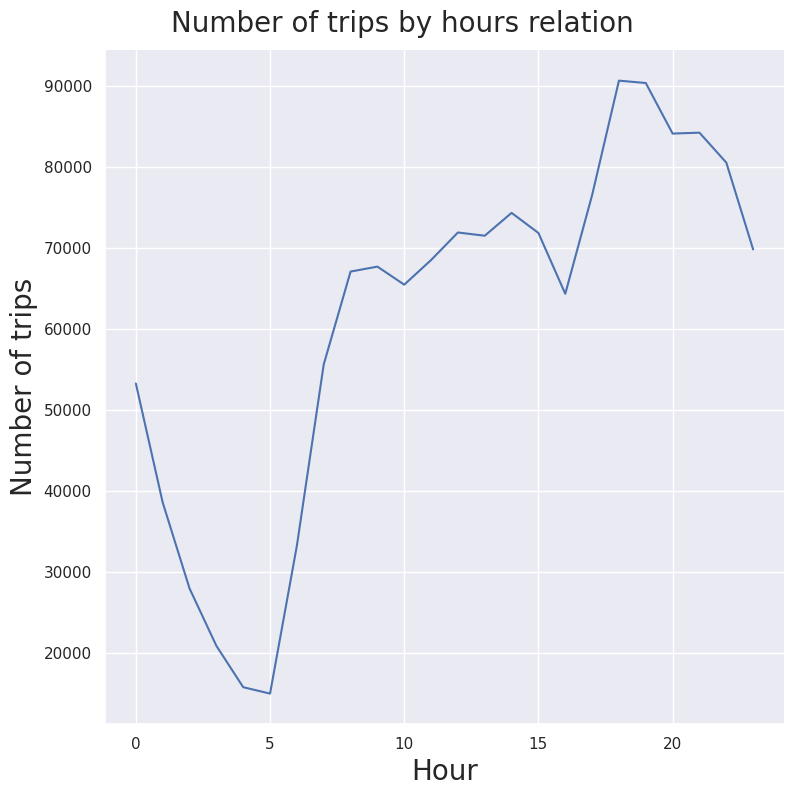

In [18]:
relation = sns.relplot(data=data_groups, x='hour', y='count', kind='line', height=8)
relation.fig.suptitle('Number of trips by hours relation', fontsize=20)
relation.fig.subplots_adjust(top=0.93)
relation.set_xlabels("Hour", fontsize=20)
relation.set_ylabels("Number of trips", fontsize=20)
plt.show()

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

In [19]:
data_groups = data.groupby([data['month'], data['hour']]).size().reset_index()
data_groups.rename(columns={0: 'count'}, inplace=True)

months = ["January", "February", "March", "April", "May", "June"]
data_groups['month'] = pd.Categorical(data_groups['month'], categories=months)
data_groups = data_groups.sort_values('month')
data_groups

month  hour  count
71  January    23  10241
48  January     0   8330
49  January     1   6400
50  January     2   4830
51  January     3   3574
..      ...   ...    ...
93     June    21  13740
94     June    22  13391
95     June    23  11899
85     June    13  11476
73     June     1   6376

[144 rows x 3 columns]

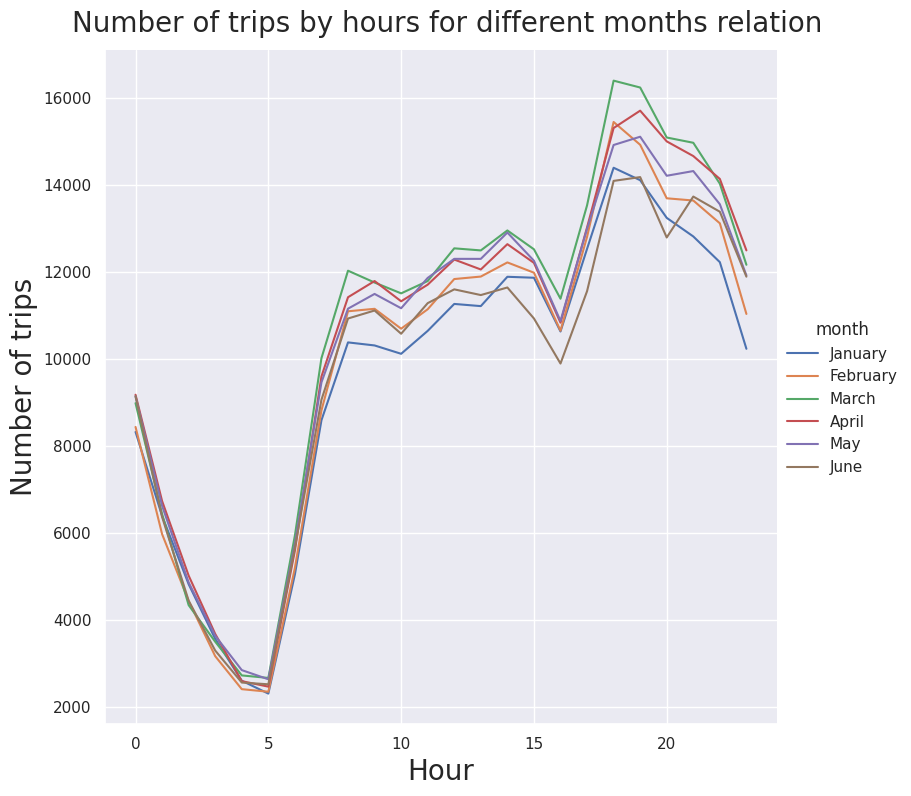

In [20]:
relation = sns.relplot(data=data_groups, x='hour', y='count', hue='month', kind='line', height=8)
relation.fig.suptitle('Number of trips by hours for different months relation', fontsize=20)
relation.fig.subplots_adjust(top=0.93)
relation.set_xlabels("Hour", fontsize=20)
relation.set_ylabels("Number of trips", fontsize=20)
plt.show()

In [21]:
data_groups = data.groupby([data['weekday'], data['hour']]).size().reset_index()
data_groups.rename(columns={0: 'count'}, inplace=True)

weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
data_groups['weekday'] = pd.Categorical(data_groups['weekday'], categories=weekdays)
data_groups = data_groups.sort_values('weekday')
data_groups

weekday  hour  count
47  Monday    23   6965
27  Monday     3   1226
28  Monday     4   1351
29  Monday     5   2147
30  Monday     6   5357
..     ...   ...    ...
75  Sunday     3   6866
74  Sunday     2   8582
73  Sunday     1  10860
82  Sunday    10   8696
83  Sunday    11  10112

[168 rows x 3 columns]

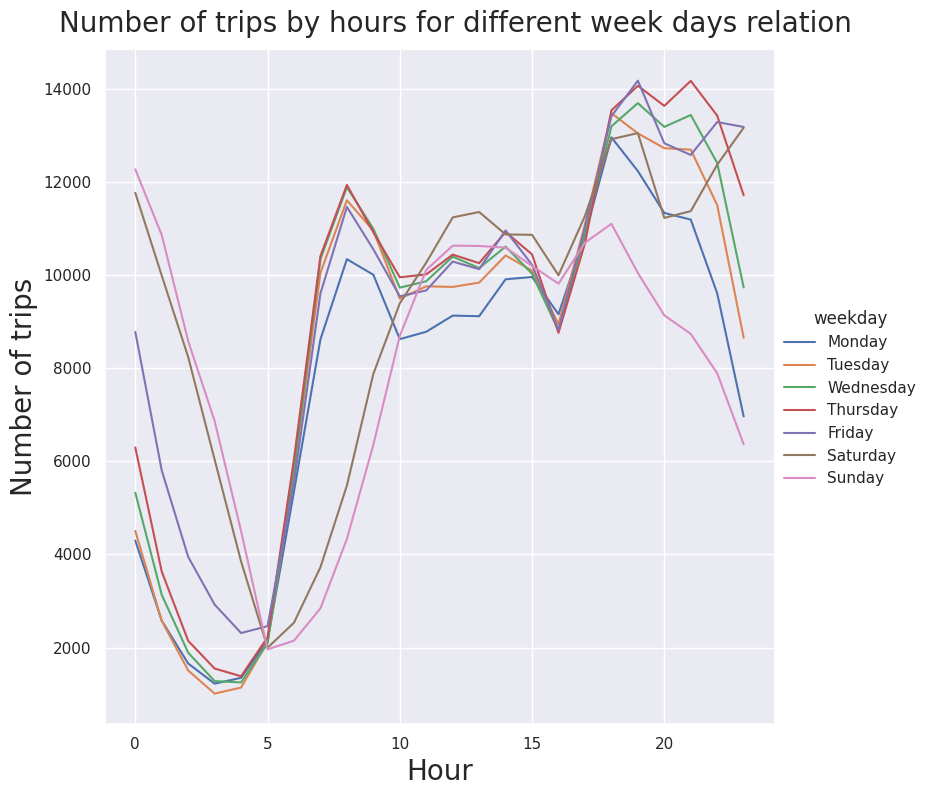

In [22]:
relation = sns.relplot(data=data_groups, x='hour', y='count', hue='weekday', kind='line', height=8)
relation.fig.suptitle('Number of trips by hours for different week days relation', fontsize=20)
relation.fig.subplots_adjust(top=0.93)
relation.set_xlabels("Hour", fontsize=20)
relation.set_ylabels("Number of trips", fontsize=20)
plt.show()

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Ответ: Есть типичные зависимости, в 5 утра желающих поездить на такси явно меньше чем в 7, когда люди едут на работу. Можно также увидеть, что например в выходные утро у людей начинается на пару часов позже, из-за чего график немного смещен. Для месяцев графики почти идентичны, говорить о каких то очевидных зависимостях не получится.**

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3 (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [23]:
from sklearn.model_selection import train_test_split

X = data
y = data['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train = X_train.reset_index()

In [24]:
train_groups = X_train.groupby(X_train['weekday']).agg({'log_trip_duration': 'mean'}).reset_index()
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
train_groups['weekday'] = pd.Categorical(train_groups['weekday'], categories=weekdays)
train_groups = train_groups.sort_values('weekday')
train_groups

weekday  log_trip_duration
1     Monday           6.426763
5    Tuesday           6.492403
6  Wednesday           6.513789
4   Thursday           6.529261
0     Friday           6.498657
2   Saturday           6.420336
3     Sunday           6.376224

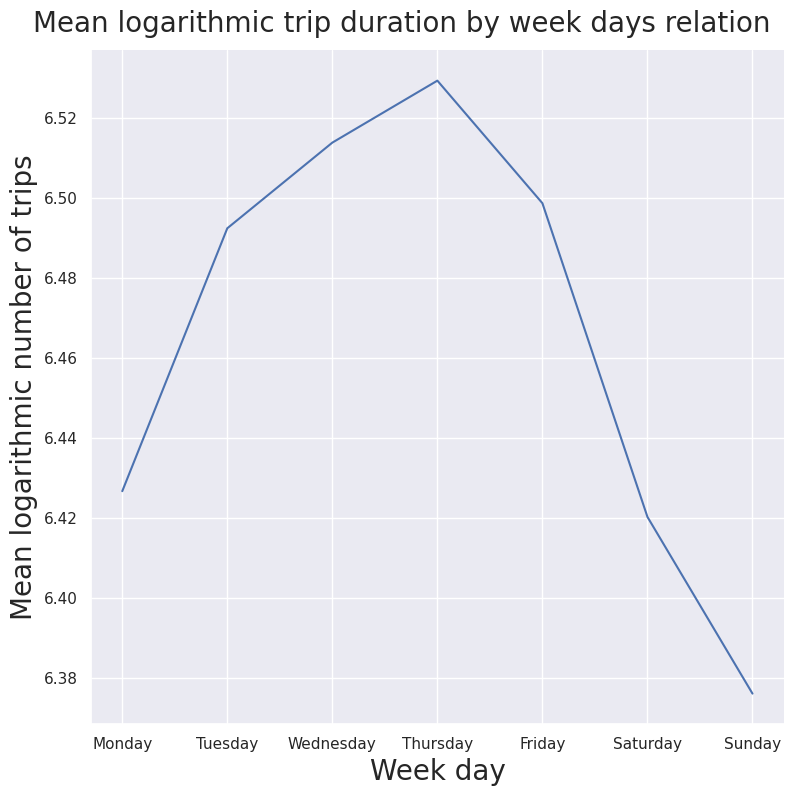

In [25]:
relation = sns.relplot(data=train_groups, x='weekday', y='log_trip_duration', kind='line', height=8)
relation.fig.suptitle('Mean logarithmic trip duration by week days relation', fontsize=20)
relation.fig.subplots_adjust(top=0.93)
relation.set_xlabels("Week day", fontsize=20)
relation.set_ylabels("Mean logarithmic number of trips", fontsize=20)
plt.show()

In [26]:
train_groups = X_train.groupby(X_train['hour']).agg({'log_trip_duration': 'mean'}).reset_index()
train_groups

hour  log_trip_duration
0      0           6.423411
1      1           6.375272
2      2           6.323034
3      3           6.313351
4      4           6.333394
5      5           6.233975
6      6           6.186678
7      7           6.350414
8      8           6.466131
9      9           6.482851
10    10           6.487758
11    11           6.520231
12    12           6.526073
13    13           6.538677
14    14           6.567917
15    15           6.568413
16    16           6.543500
17    17           6.538253
18    18           6.505015
19    19           6.439382
20    20           6.419806
21    21           6.432670
22    22           6.465609
23    23           6.468741

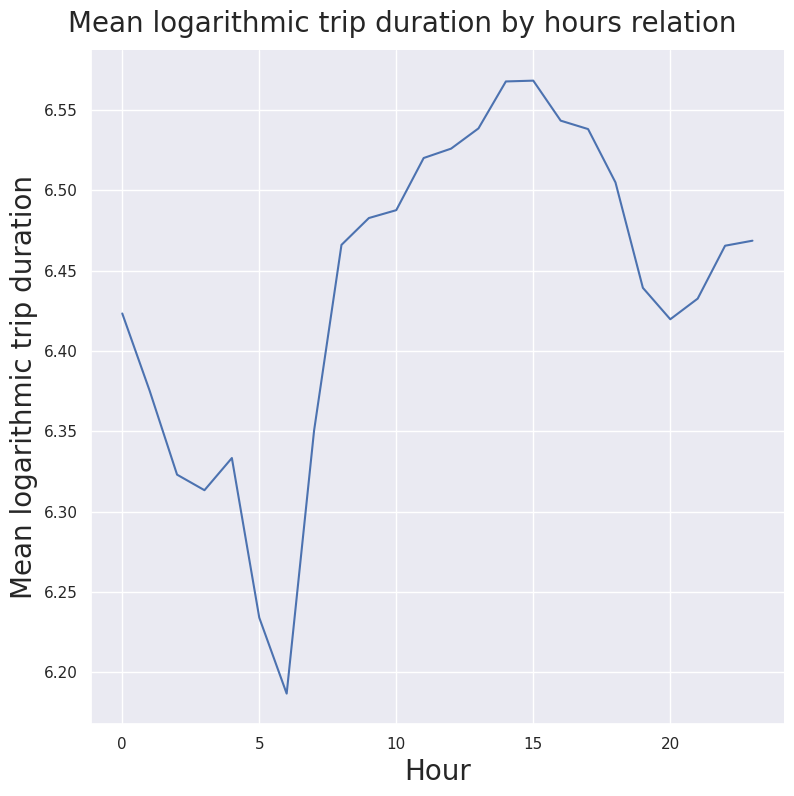

In [27]:
relation = sns.relplot(data=train_groups, x='hour', y='log_trip_duration', kind='line', height=8)
relation.fig.suptitle('Mean logarithmic trip duration by hours relation', fontsize=20)
relation.fig.subplots_adjust(top=0.93)
relation.set_xlabels("Hour", fontsize=20)
relation.set_ylabels("Mean logarithmic trip duration", fontsize=20)
plt.show()

In [28]:
train_groups = X_train.groupby(X_train['pickup_datetime'].dt.date).agg({'log_trip_duration': 'mean'}).reset_index()
train_groups.rename(columns={'pickup_datetime': 'date'}, inplace=True)
train_groups

date  log_trip_duration
0    2016-01-01           6.336530
1    2016-01-02           6.310629
2    2016-01-03           6.327419
3    2016-01-04           6.307745
4    2016-01-05           6.363087
..          ...                ...
177  2016-06-26           6.454265
178  2016-06-27           6.480539
179  2016-06-28           6.491671
180  2016-06-29           6.540048
181  2016-06-30           6.546199

[182 rows x 2 columns]

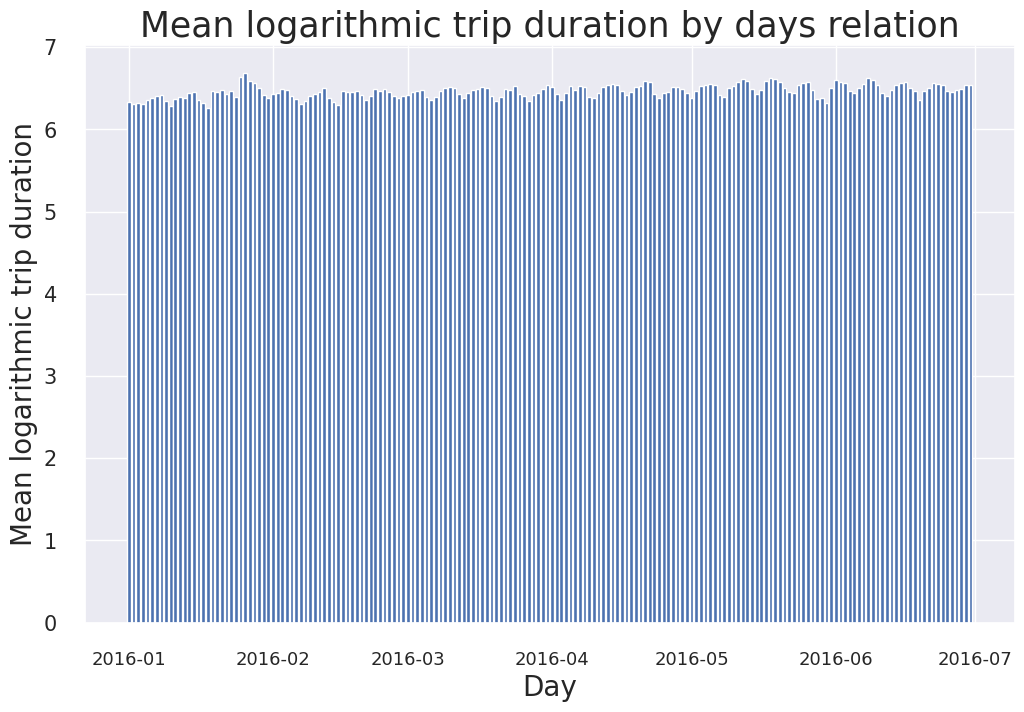

In [29]:
fig = plt.figure(figsize=(12, 7.5))
ax = fig.add_subplot(111)
plt.bar(train_groups['date'], train_groups['log_trip_duration'])
ax.set_title("Mean logarithmic trip duration by days relation", fontsize=25)
ax.set_xlabel("Day", fontsize=20)
ax.set_ylabel("Mean logarithmic trip duration", fontsize=20)
ax.tick_params(axis='y',
               which='major',
               direction='inout',
               length=10,
               width=1.5,
               pad=15,
               labelsize=15
               )
ax.tick_params(axis='x',
               which='major',
               direction='inout',
               length=10,
               width=1.5,
               pad=15,
               labelsize=13
               )
plt.show()

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

**Ответ: Да, некотроая схожесть присутствует из-за логической связи величин. Например, можно увидеть провал по количеству поездок в 5 утра и снижение средней продолжительности поездки в это же время. Это скорее всего происходит из-за того, что в это время нет пробок, все поездки проходят быстрее, следовательно время снижается. То же самое можно сказать и про дни недели. На последнем графике можно увидеть волнообразное движение времени поездки, это связано с тем, что в этот график заложена зависимость и от дней недели, в которой как мы видели есть провалы по понедельникам и воскресеньям.**

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [30]:
# Часть уже добавили ранее
data['day_num'] = data['pickup_datetime'].dt.dayofyear
data['is_critical_23'] = (data['day_num'] == 23)
data['is_critical_24'] = (data['day_num'] == 24)
data.head(5)

id  vendor_id     pickup_datetime  passenger_count  \
0  id2875421          2 2016-03-14 17:24:55                1   
1  id2377394          1 2016-06-12 00:43:35                1   
2  id3858529          2 2016-01-19 11:35:24                1   
3  id3504673          2 2016-04-06 19:32:31                1   
4  id2181028          2 2016-03-26 13:30:55                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.982155        40.767937         -73.964630         40.765602   
1        -73.980415        40.738564         -73.999481         40.731152   
2        -73.979027        40.763939         -74.005333         40.710087   
3        -74.010040        40.719971         -74.012268         40.706718   
4        -73.973053        40.793209         -73.972923         40.782520   

  store_and_fwd_flag  trip_duration  log_trip_duration  hour    weekday  \
0                  N            455           6.122493    17     Monday   
1                  N            663           6.498282     0     Sunday   
2                  N           2124           7.661527    11    Tuesday   
3                  N            429           6.063785    19  Wednesday   
4                  N            435           6.077642    13   Saturday   

     month  day_num  is_critical_23  is_critical_24  
0    March       74           False           False  
1     June      164           False           False  
2  January       19           False           False  
3    April       97           False           False  
4    March       86           False           False

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?

**Ответ: Дни недели, месяцы и часы стоит рассматривать как категориальные, так как они нелинейно влияют на нашу модель (это видно из всех графиков выше). Признаки аномальности изначально являются категориальными, а номера дней можно оставить числовыми.**

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [31]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

y = data['log_trip_duration']
X = data[['hour',
          'weekday',
          'month',
          'day_num',
          'is_critical_23',
          'is_critical_24']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


categorical = ['month',
               'weekday',
               'hour',
               'is_critical_23',
               'is_critical_24']
numeric = ['day_num']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])


const_arr = np.empty(len(y_test))
const_arr.fill(np.log1p(np.exp(np.sum(y_train) / len(y_train))))
print("RMSLE const error:", rmsle(const_arr, y_test))

prediction = pipeline.fit(X_train, y_train).predict(X_test)
print("RMSLE ridge error:", rmsle(prediction, y_test))

RMSLE const error: 0.7950290458980199
RMSLE ridge error: 0.7882504231432342


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [32]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.

    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [33]:
show_circles_on_map(data.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [34]:
show_circles_on_map(data.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?

**Ответ: На карте явно видно 3 скопления точек, отличных от общего центрального кластера. Это аэропорты Кеннеди, Ла-Гвардия и Ньюаркский. Эти места явно будут популярны среди всех возможных маршрутов и их стоит выделить.**

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [35]:
# код с семинара
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h


data['haversine'] = haversine_array(data['pickup_latitude'], data['pickup_longitude'], data['dropoff_latitude'], data['dropoff_longitude'])

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

In [36]:
data['log_haversine'] = np.log1p(data['haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [37]:
your_df = data
assert your_df['log_haversine'].corr(your_df['log_trip_duration']) > your_df['haversine'].corr(your_df['log_trip_duration'])

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

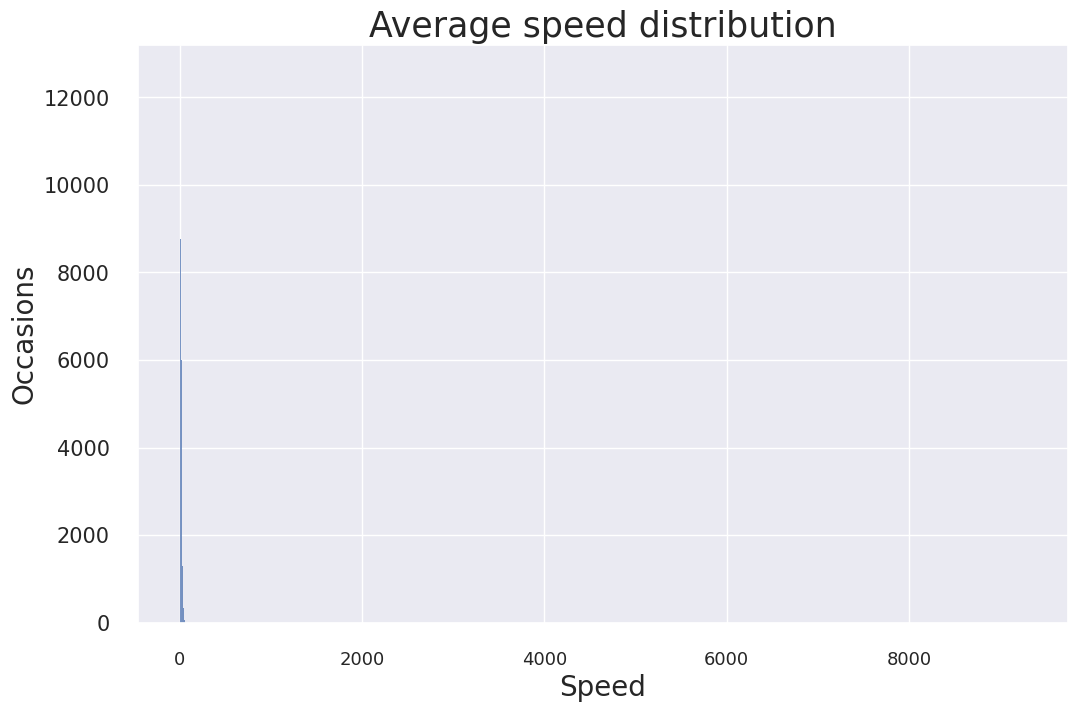

In [38]:
y = data['log_trip_duration']
X = data.drop(columns='log_trip_duration')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train['average_speed'] = X_train['haversine'] / X_train['trip_duration'] * 3600

fig = plt.figure(figsize=(12, 7.5))
ax = fig.add_subplot(111)
sns.histplot(X_train['average_speed'])
ax.set_title("Average speed distribution", fontsize=25)
ax.set_xlabel("Speed", fontsize=20)
ax.set_ylabel("Occasions", fontsize=20)
ax.tick_params(axis='y',
               which='major',
               direction='inout',
               length=10,
               width=1.5,
               pad=15,
               labelsize=15
               )
ax.tick_params(axis='x',
               which='major',
               direction='inout',
               length=10,
               width=1.5,
               pad=15,
               labelsize=13
               )
plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

**Едва ли следует рассматривать записи со средней скоростью больше 150км/ч, так как такая скорость не разрешена даже на автомагистралях (тем более в черте города).**

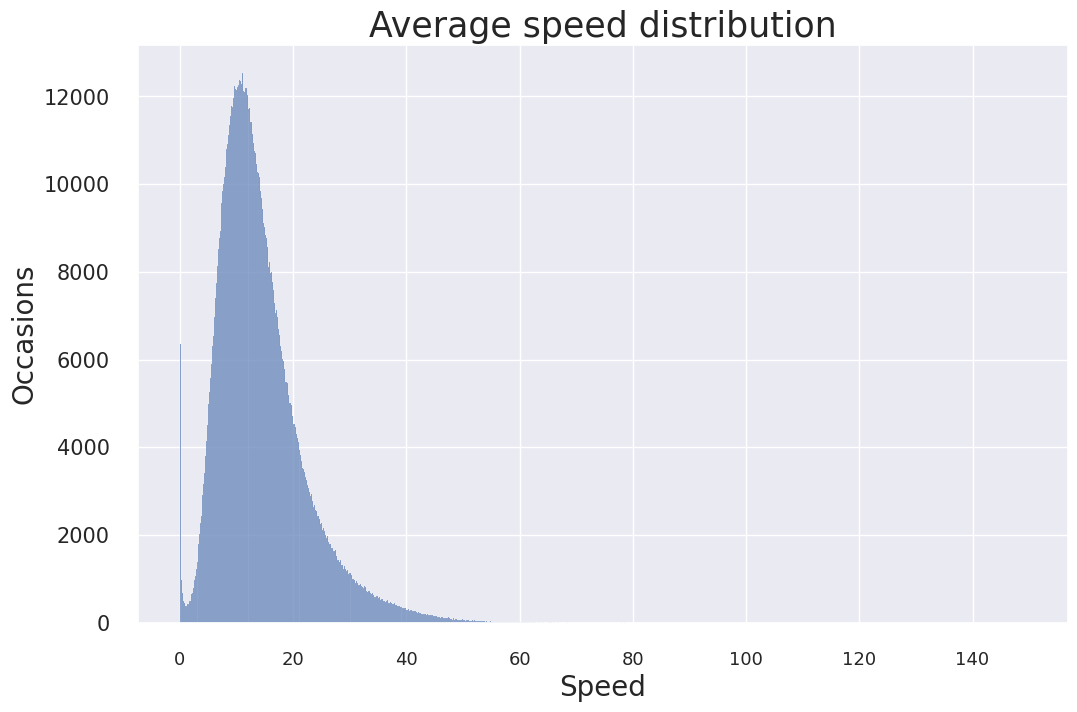

In [39]:
fig = plt.figure(figsize=(12, 7.5))
ax = fig.add_subplot(111)
sns.histplot(X_train[X_train['average_speed'] < 150]['average_speed'])
ax.set_title("Average speed distribution", fontsize=25)
ax.set_xlabel("Speed", fontsize=20)
ax.set_ylabel("Occasions", fontsize=20)
ax.tick_params(axis='y',
               which='major',
               direction='inout',
               length=10,
               width=1.5,
               pad=15,
               labelsize=15
               )
ax.tick_params(axis='x',
               which='major',
               direction='inout',
               length=10,
               width=1.5,
               pad=15,
               labelsize=13
               )
plt.show()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

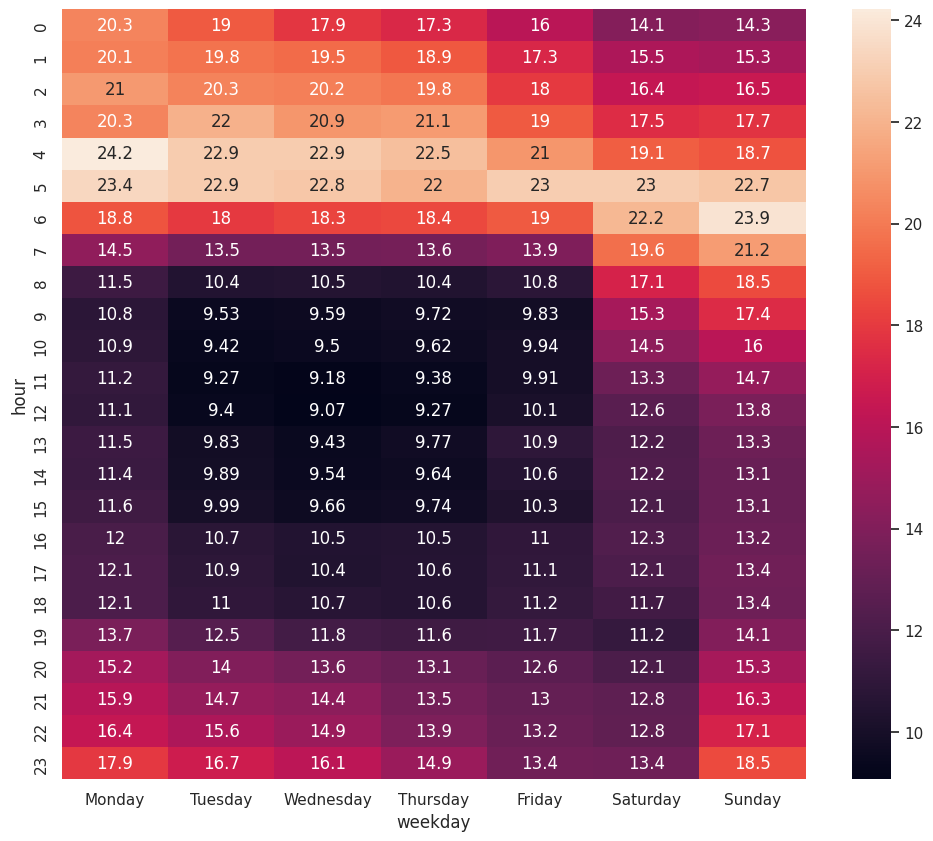

In [40]:
train_groups = X_train.groupby(['weekday', 'hour']).agg({'average_speed': 'median'}).reset_index()
train_groups.rename(columns={'average_speed': 'speed_median'}, inplace=True)

weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
train_groups['weekday'] = pd.Categorical(train_groups['weekday'], categories=weekdays)
train_groups = train_groups.sort_values('weekday')

df_heatmap = train_groups.pivot("hour", "weekday", "speed_median")

plt.figure(figsize=(12, 10))
sns.heatmap(df_heatmap, annot=True, fmt='.3g')
plt.show()

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

**Ответ: Скорость поездки нерепрезентативный признак, так как она является не причиной изменения показателя длительности поездки, а следствием других факторов - например, пробок.**

In [41]:
X_train.drop(columns='average_speed', inplace=True)

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

**Ответ: В целом, картина совпадает с реалистичными пробками - днем скорости довольно малы, а по ночам большие.**

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

**Посмотрим еще на количество поездок - в целом количество вызванных такси должно хорошо кореллировать с количеством машин на дороге.
Соотнесем это со скоростью и поймем, какое количество такси может означать пробки на дорогах.**

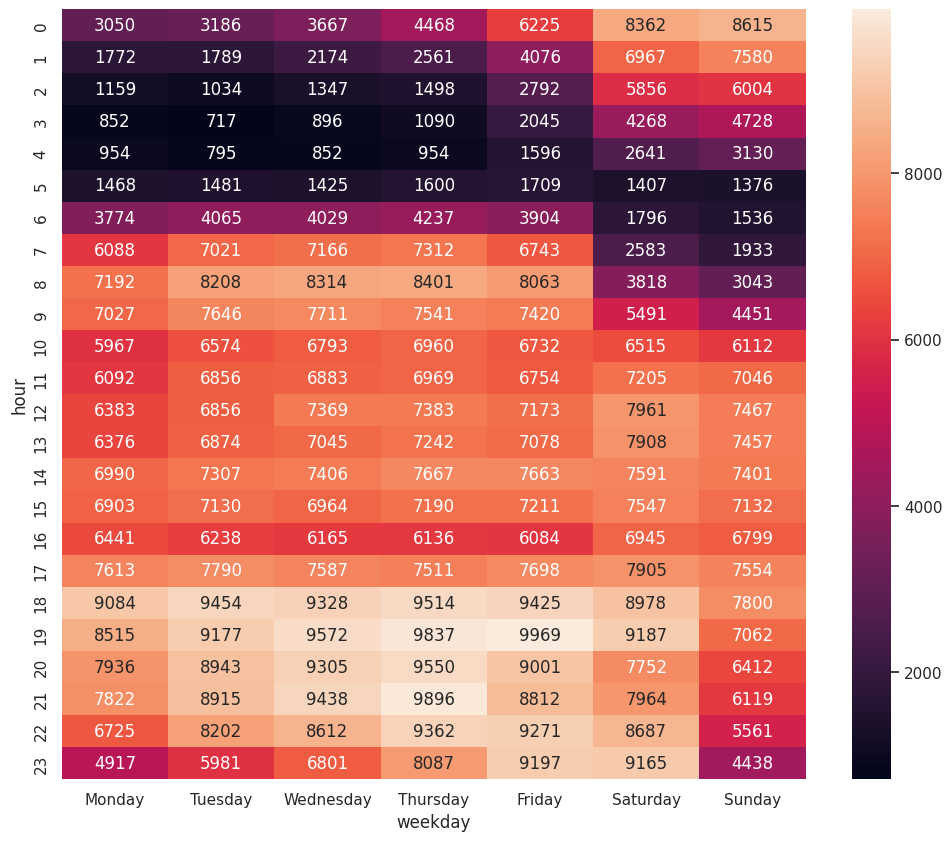

In [42]:
train_groups = X_train.groupby(['weekday', 'hour']).size().reset_index()
train_groups.rename(columns={0: 'count'}, inplace=True)
train_groups

weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
train_groups['weekday'] = pd.Categorical(train_groups['weekday'], categories=weekdays)
train_groups = train_groups.sort_values('weekday')

df_heatmap = train_groups.pivot("hour", "weekday", "count")

plt.figure(figsize=(12, 10))
sns.heatmap(df_heatmap, annot=True, fmt='.4g')
plt.show()

In [43]:
data = data.merge(train_groups, on=['weekday', 'hour'])
data['no_traffic'] = data['count'] < 2000
data['heavy_traffic'] = data['count'] > 5000
data.drop(columns='count', inplace=True)

**Задание 8 (0.25 балла)**. Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака:
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте

Как вы думаете, почему эти признаки могут быть полезны?

**Ответ: Раз есть некие отклонения и скопления точек вне основного кластера, которые не являются случайными - должны быть учтены признаки, показывающие это отклонение как что то влияющее на модель.**

In [44]:
data['is_la_gvardia_airport_start'] = haversine_array(data['pickup_latitude'], data['pickup_longitude'], 40.774679, -73.871784) < 1.2
data['is_la_gvardia_airport_end'] = haversine_array(40.774679, -73.871784, data['dropoff_latitude'], data['dropoff_longitude']) < 1.2

data['is_kennedi_airport_start'] = haversine_array(data['pickup_latitude'], data['pickup_longitude'], 40.645814, -73.786613) < 2
data['is_kennedi_airport_end'] = haversine_array(40.645814, -73.786613, data['dropoff_latitude'], data['dropoff_longitude']) < 2

data['is_newark_airport_start'] = haversine_array(data['pickup_latitude'], data['pickup_longitude'], 40.691611, -74.180221) < 1
data['is_newark_airport_end'] = haversine_array(40.691611, -74.180221, data['dropoff_latitude'], data['dropoff_longitude']) < 1

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

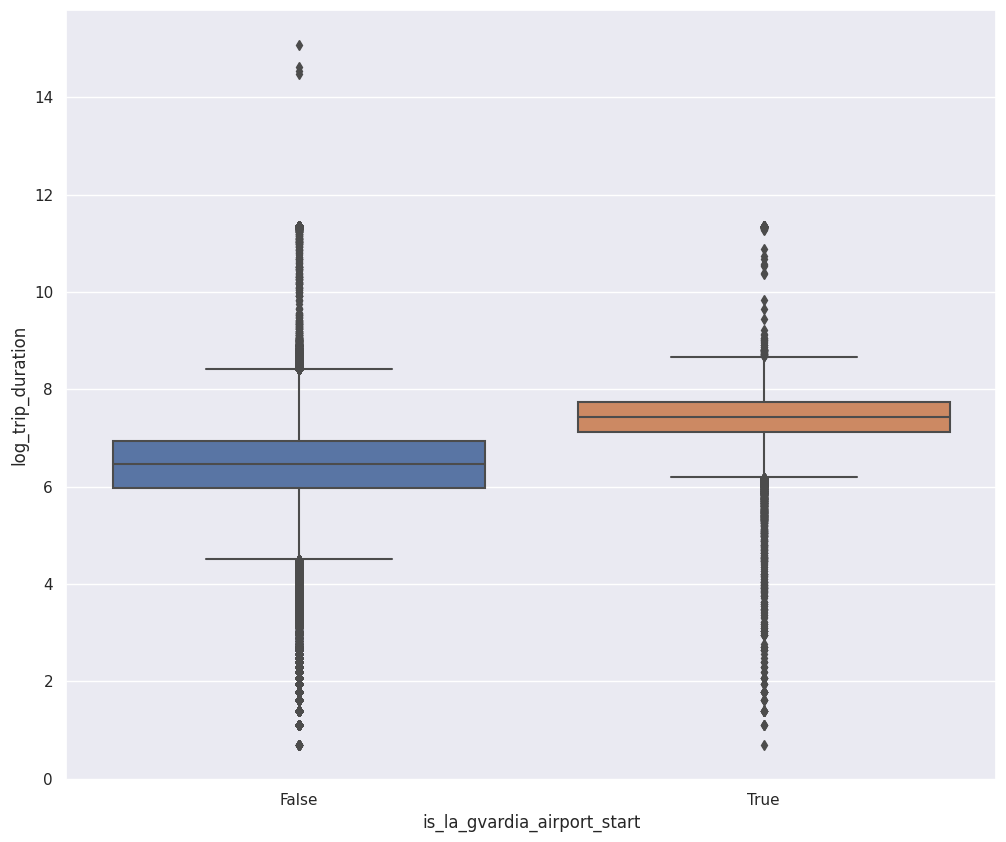

In [45]:
plt.figure(figsize=(12, 10))
sns.boxplot(data=data, x='is_la_gvardia_airport_start', y="log_trip_duration")
plt.show()

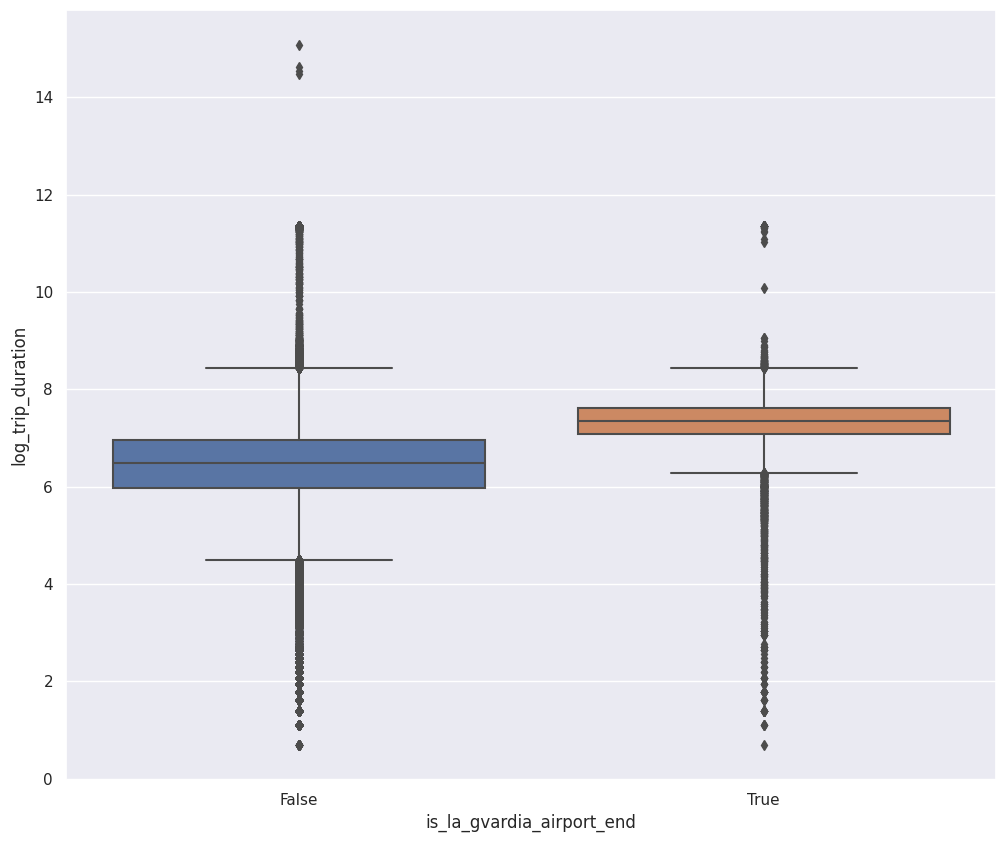

In [46]:
plt.figure(figsize=(12, 10))
sns.boxplot(data=data, x='is_la_gvardia_airport_end', y="log_trip_duration")
plt.show()

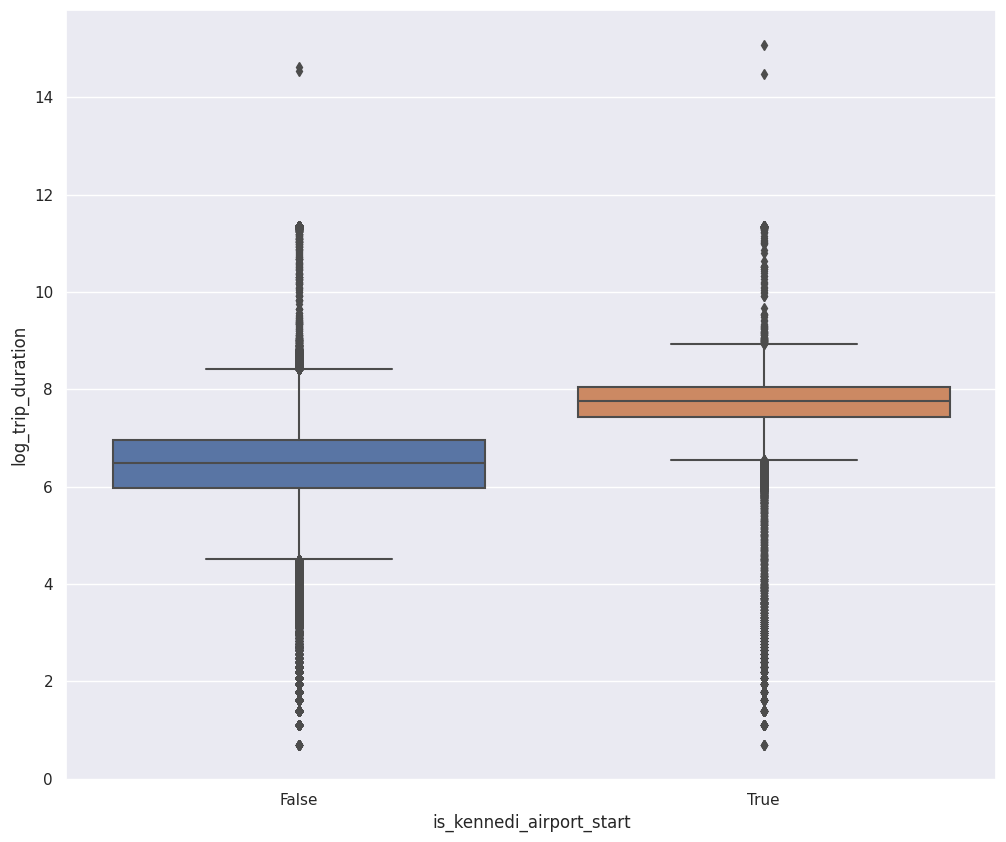

In [47]:
plt.figure(figsize=(12, 10))
sns.boxplot(data=data, x='is_kennedi_airport_start', y="log_trip_duration")
plt.show()

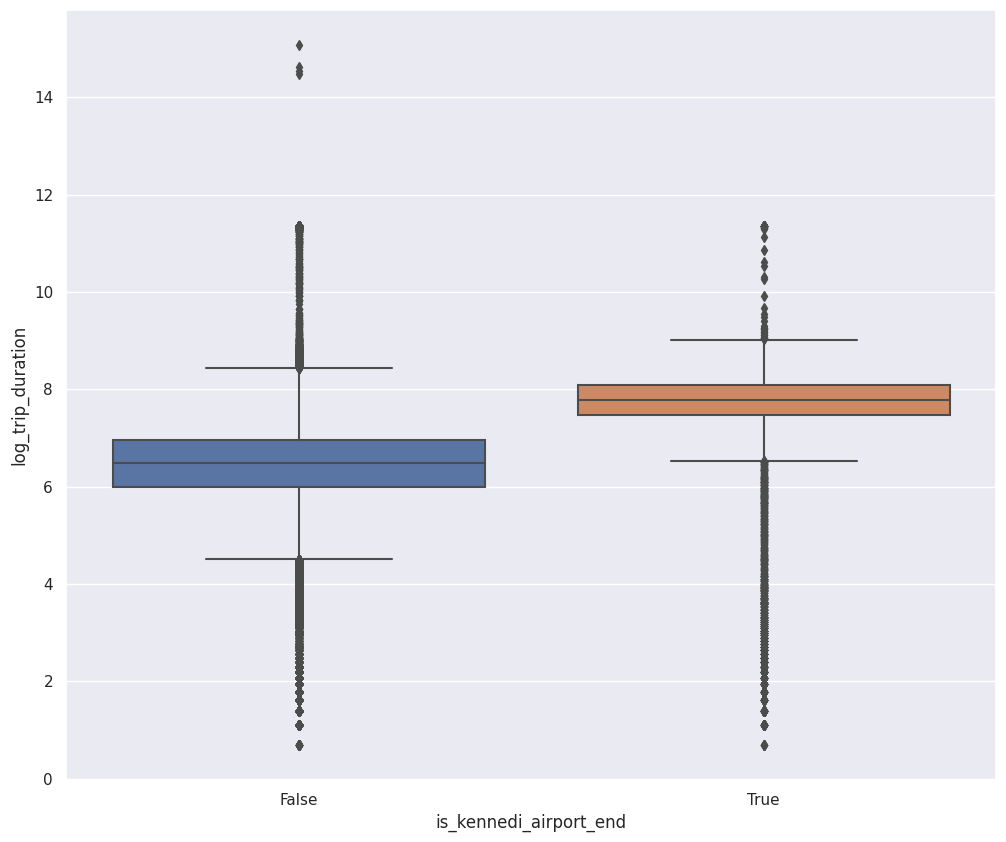

In [48]:
plt.figure(figsize=(12, 10))
sns.boxplot(data=data, x='is_kennedi_airport_end', y="log_trip_duration")
plt.show()

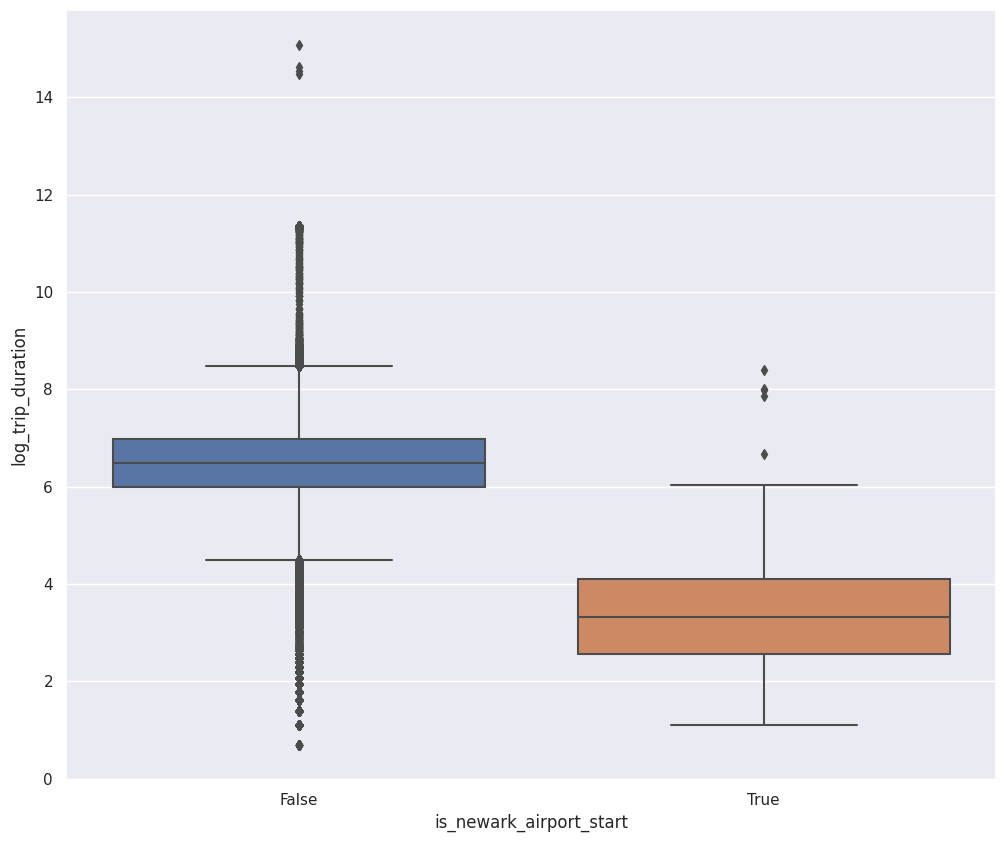

In [49]:
plt.figure(figsize=(12, 10))
sns.boxplot(data=data, x='is_newark_airport_start', y="log_trip_duration")
plt.show()

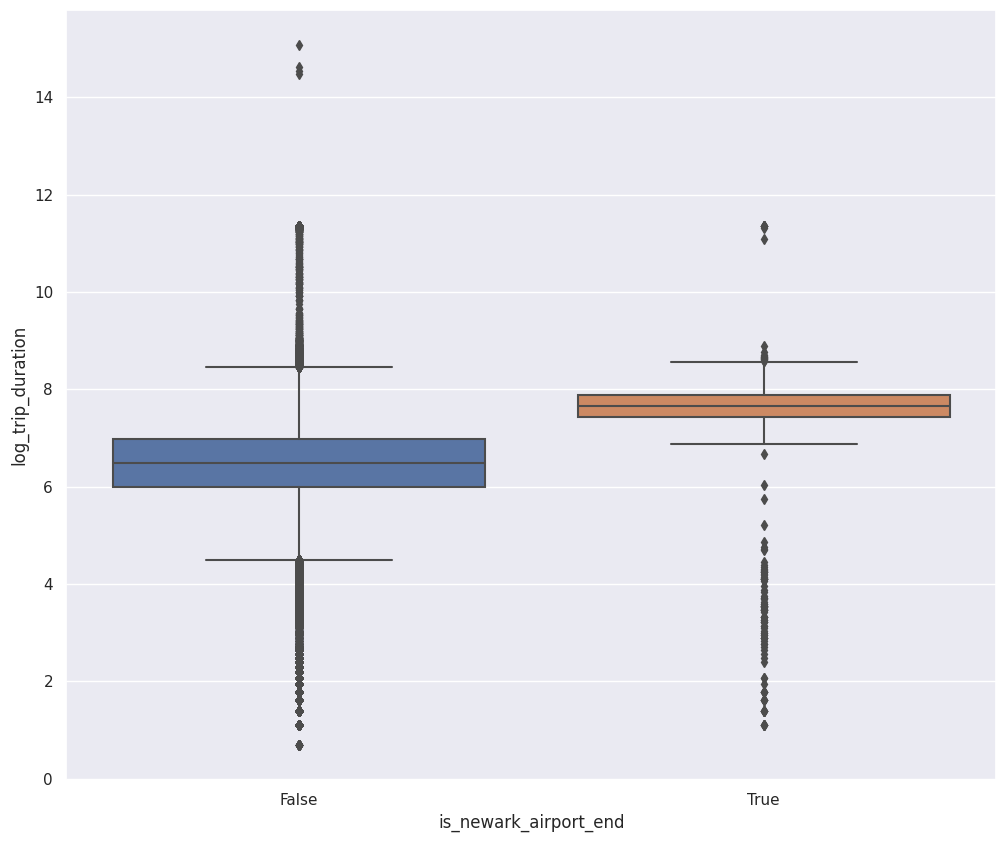

In [50]:
plt.figure(figsize=(12, 10))
sns.boxplot(data=data, x='is_newark_airport_end', y="log_trip_duration")
plt.show()

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

**Ответ: Судя по графикам, качество этих признаков в целом приемлемое, хотя и не принесет такого заметного улучшения в модель, как например расстояние от точки до точки.**


<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

**Сначала посмотрим, где собственно находятся точки и подберем необходимые границы прямоугольника.**

In [51]:
def dotter(data, latitude_column, longitude_column, color, map_obj):
    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(map_obj)
    return map_obj


location = (data["pickup_latitude"].mean(), data["pickup_longitude"].mean())
map_obj = folium.Map(width=500, height=500, location=location, zoom_start=12)
map_obj = dotter(data.sample(1000), "pickup_latitude", "pickup_longitude", "blue", map_obj)
map_obj = dotter(data.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue", map_obj)
folium.Rectangle([(40.703314, -74.018608), (40.791438, -73.949241)]).add_to(map_obj)
map_obj

In [52]:
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.spatial.distance import cdist
from math import floor

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cols, rows):
        self.col = cols
        self.row = rows

    def show_map(self):
        pass

    def fit(self, X=None, y=None):
        self.lat_min = 40.703314
        self.lat_max = 40.791438
        self.lon_min = -74.018608
        self.lon_max = -73.949241
        self.lat_dist = (self.lat_max - self.lat_min) / self.col
        self.lon_dist = (self.lon_max - self.lon_min) / self.row
        return self

    def transform(self, X, y=None):
        res = X.copy(deep=True)
        res['pickup_lat_col'] = (res['pickup_latitude'] - self.lat_min) // self.lat_dist
        res['pickup_lon_row'] = (res['pickup_longitude'] - self.lon_min) // self.lon_dist
        res['dropoff_lat_col'] = (res['dropoff_latitude'] - self.lat_min) // self.lat_dist
        res['dropoff_lon_row'] = (res['dropoff_longitude'] - self.lon_min) // self.lon_dist

        res.loc[(res['pickup_lat_col'] < 0) | (res['pickup_lat_col'] >= self.col) | (res['pickup_lon_row'] < 0) | (res['pickup_lon_row'] > self.col) , 'pickup_idx'] = -1
        res.loc[(res['dropoff_lat_col'] < 0) | (res['dropoff_lat_col'] >= self.col) | (res['dropoff_lon_row'] < 0) | (res['dropoff_lon_row'] > self.col) , 'dropoff_idx'] = -1

        res.loc[res['pickup_idx'] != -1 , 'pickup_idx'] = res['pickup_lat_col'] * self.col + res['pickup_lon_row']
        res.loc[res['dropoff_idx'] != -1 , 'dropoff_idx'] = res['dropoff_lat_col'] * self.col + res['dropoff_lon_row']
        res.drop(columns=['pickup_lat_col', 'pickup_lon_row', 'dropoff_lat_col', 'dropoff_lon_row'], inplace=True)
        return res


a = MapGridTransformer(25, 25)
data = a.fit().transform(data)

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [53]:
y = data['log_trip_duration']
X = data[['hour',
          'weekday',
          'month',
          'day_num',
          'is_critical_23',
          'is_critical_24',
          'log_haversine',
          'no_traffic',
          'heavy_traffic',
          'is_la_gvardia_airport_start',
          'is_la_gvardia_airport_end',
          'is_kennedi_airport_start',
          'is_kennedi_airport_end',
          'is_newark_airport_start',
          'is_newark_airport_end',
          'pickup_idx',
          'dropoff_idx']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

categorical = ['month',
               'weekday',
               'hour',
               'is_critical_23',
               'is_critical_24',
               'no_traffic',
               'heavy_traffic',
               'is_la_gvardia_airport_start',
               'is_la_gvardia_airport_end',
               'is_kennedi_airport_start',
               'is_kennedi_airport_end',
               'is_newark_airport_start',
               'is_newark_airport_end',
               'pickup_idx',
               'dropoff_idx']
numeric = ['day_num', 'log_haversine']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

prediction = pipeline.fit(X_train, y_train).predict(X_test)
print("RMSLE ridge error:", rmsle(prediction, y_test))

RMSLE ridge error: 0.466079389103694


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

**Ответ: Во-первых, это дополнительная возможность найти выбросы и ошибки в остальных данных. Во-вторых, разные вендоры могут иметь разные условия (в виде машин, например), что может изменять таргетное время.**

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [54]:
print(sorted(data['vendor_id'].unique()))
print(sorted(data['passenger_count'].unique()))
print(sorted(data['store_and_fwd_flag'].unique()))

[1, 2]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
['N', 'Y']


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

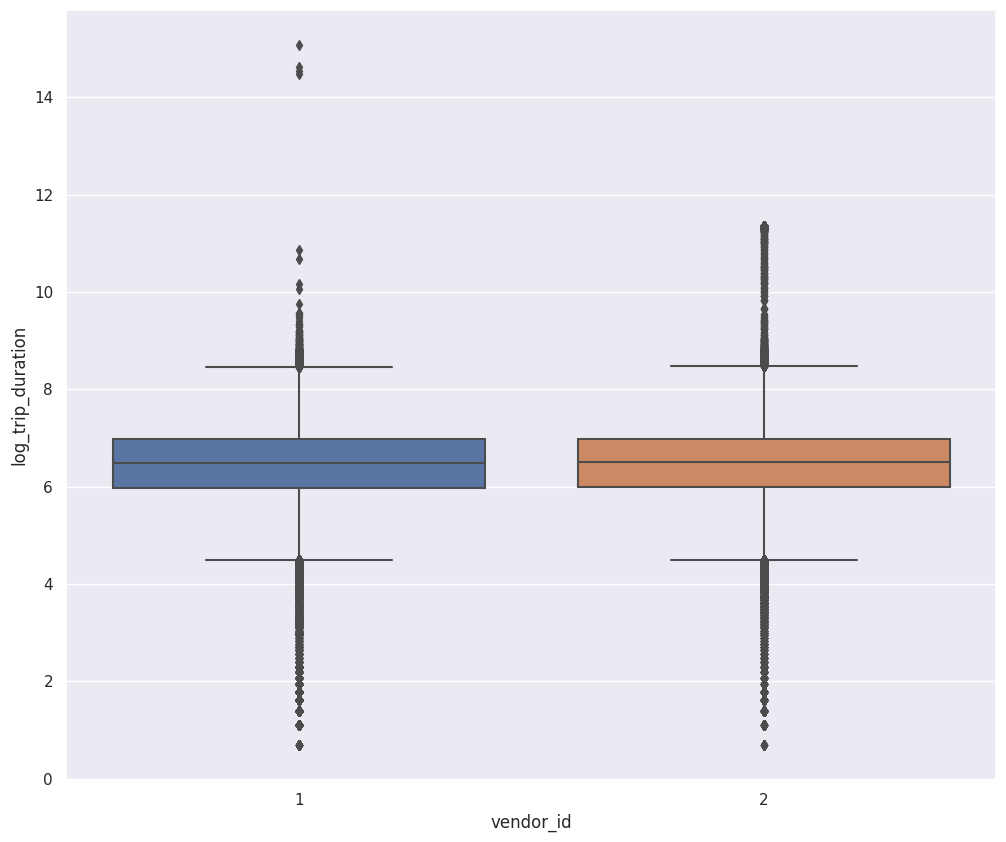

In [55]:
plt.figure(figsize=(12, 10))
sns.boxplot(data=data, x='vendor_id', y="log_trip_duration")
plt.show()

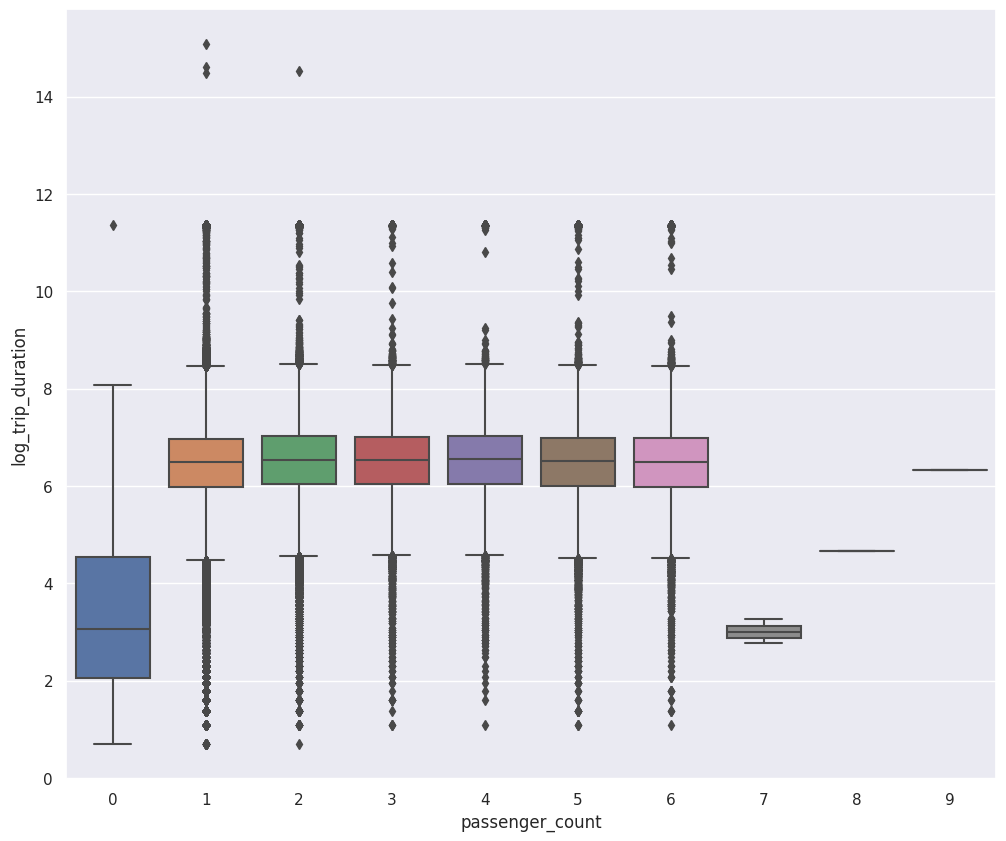

In [56]:
plt.figure(figsize=(12, 10))
sns.boxplot(data=data, x='passenger_count', y="log_trip_duration")
plt.show()

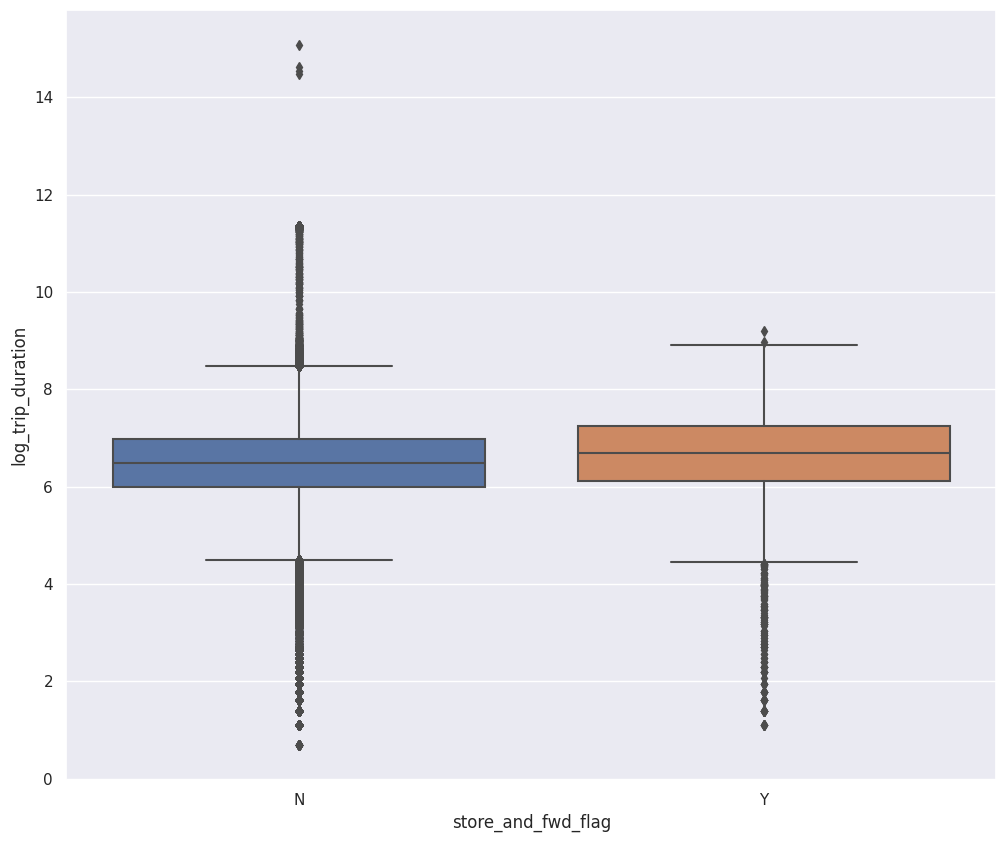

In [57]:
plt.figure(figsize=(12, 10))
sns.boxplot(data=data, x='store_and_fwd_flag', y="log_trip_duration")
plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [58]:
replacer = {1 : 0, 2 : 1}
data['vendor_id'] = data['vendor_id'].map(replacer)
replacer = {'N' : 0, 'Y' : 1}
data['store_and_fwd_flag'] = data['store_and_fwd_flag'].map(replacer)

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Ответ: Скорее всего нет, они ничего не дадут. Числло пассажиров равное 0 и большее 6 выглядит просто как выбросы, а остальные признаки не очень репрезентативны.**


**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [59]:
y = data['log_trip_duration']
X = data[['hour',
          'weekday',
          'month',
          'day_num',
          'is_critical_23',
          'is_critical_24',
          'log_haversine',
          'no_traffic',
          'heavy_traffic',
          'is_la_gvardia_airport_start',
          'is_la_gvardia_airport_end',
          'is_kennedi_airport_start',
          'is_kennedi_airport_end',
          'is_newark_airport_start',
          'is_newark_airport_end',
          'pickup_idx',
          'dropoff_idx',
          'vendor_id',
          'passenger_count',
          'store_and_fwd_flag']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

categorical = ['month',
               'weekday',
               'hour',
               'is_critical_23',
               'is_critical_24',
               'no_traffic',
               'heavy_traffic',
               'is_la_gvardia_airport_start',
               'is_la_gvardia_airport_end',
               'is_kennedi_airport_start',
               'is_kennedi_airport_end',
               'is_newark_airport_start',
               'is_newark_airport_end',
               'pickup_idx',
               'dropoff_idx',
               'vendor_id',
               'passenger_count',
               'store_and_fwd_flag']
numeric = ['day_num', 'log_haversine']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

prediction = pipeline.fit(X_train, y_train).predict(X_test)
print("RMSLE ridge error:", rmsle(prediction, y_test))

RMSLE ridge error: 0.4656595122596975


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

**Прирост очень сомнительный, брать не будем.**

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите __обучающую выборку__ от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

**Мы уже рисовали такие гистограммы ранее по заданиям, по ним можно увидеть что достаточно выбросить некоторые краевые значения, например по 98-квантилю.
Так же есть странные объекты, у которых длина пройденного расстояния - 0, их нужно удалить дополнительно. Для регрессии построим график и посмотрим на него.**

<ipython-input-60-22acb24b3464>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error)


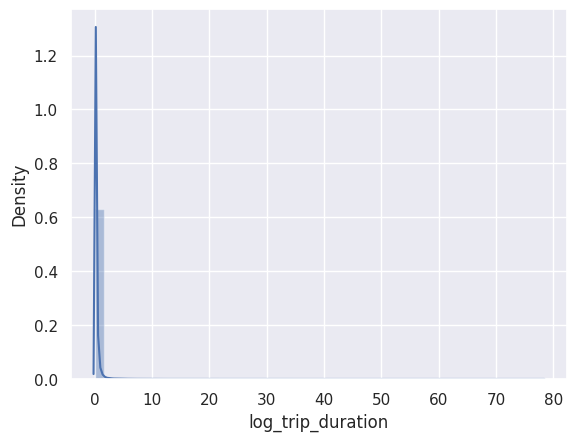

In [60]:
train_prediction = pipeline.fit(X_train, y_train).predict(X_train)
error = (y_train - train_prediction) ** 2
sns.distplot(error)
plt.show()

**Срежем 95-квантиль по полученным выбросам регрессии.**

In [61]:
mask = (error < np.quantile(error, 0.95))

In [62]:
X_train, X_test, y_train, y_test = train_test_split(data, data, test_size=0.3, random_state=42)
X_train = X_train[mask]
X_train = X_train[X_train['trip_duration'] > 0]
X_train = X_train[X_train['haversine'] > 0]
quartile_99_5 = round(len(X_train) * 0.995)
X_train = X_train.sort_values(by=['trip_duration']).head(quartile_99_5)
quartile_99_5 = round(len(X_train) * 0.995)
X_train = X_train.tail(quartile_99_5)
quartile_99_5 = round(len(X_train) * 0.995)
X_train = X_train.sort_values(by=['haversine']).head(quartile_99_5)
X_train = X_train.reset_index()
X_test = X_test.reset_index()

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие).

In [63]:
clear_groups = data.groupby('pickup_idx').size().reset_index().sort_values(by=[0])
clear_groups = clear_groups[clear_groups[0] < 100]

X_train.loc[X_train['pickup_idx'].isin(clear_groups['pickup_idx']), 'pickup_idx'] = -1
X_test.loc[X_test['pickup_idx'].isin(clear_groups['pickup_idx']), 'pickup_idx'] = -1

clear_groups = data.groupby('dropoff_idx').size().reset_index().sort_values(by=[0])
clear_groups = clear_groups[clear_groups[0] < 100]

X_train.loc[X_train['dropoff_idx'].isin(clear_groups['dropoff_idx']), 'dropoff_idx'] = -1
X_test.loc[X_test['dropoff_idx'].isin(clear_groups['dropoff_idx']), 'dropoff_idx'] = -1

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [64]:
y_train = X_train['log_trip_duration']
X_train = X_train[['hour',
          'weekday',
          'month',
          'day_num',
          'is_critical_23',
          'is_critical_24',
          'log_haversine',
          'no_traffic',
          'heavy_traffic',
          'is_la_gvardia_airport_start',
          'is_la_gvardia_airport_end',
          'is_kennedi_airport_start',
          'is_kennedi_airport_end',
          'is_newark_airport_start',
          'is_newark_airport_end',
          'pickup_idx',
          'dropoff_idx']]
y_test = X_test['log_trip_duration']
X_test = X_test[['hour',
          'weekday',
          'month',
          'day_num',
          'is_critical_23',
          'is_critical_24',
          'log_haversine',
          'no_traffic',
          'heavy_traffic',
          'is_la_gvardia_airport_start',
          'is_la_gvardia_airport_end',
          'is_kennedi_airport_start',
          'is_kennedi_airport_end',
          'is_newark_airport_start',
          'is_newark_airport_end',
          'pickup_idx',
          'dropoff_idx']]

categorical = ['month',
               'weekday',
               'hour',
               'is_critical_23',
               'is_critical_24',
               'no_traffic',
               'heavy_traffic',
               'is_la_gvardia_airport_start',
               'is_la_gvardia_airport_end',
               'is_kennedi_airport_start',
               'is_kennedi_airport_end',
               'is_newark_airport_start',
               'is_newark_airport_end',
               'pickup_idx',
               'dropoff_idx']
numeric = ['day_num', 'log_haversine']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

prediction = pipeline.fit(X_train, y_train).predict(X_test)
print("RMSLE ridge error:", rmsle(prediction, y_test))

RMSLE ridge error: 0.46690852858560616


**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [65]:
X = data[['hour',
          'weekday',
          'month',
          'day_num',
          'is_critical_23',
          'is_critical_24',
          'log_haversine',
          'no_traffic',
          'heavy_traffic',
          'is_la_gvardia_airport_start',
          'is_la_gvardia_airport_end',
          'is_kennedi_airport_start',
          'is_kennedi_airport_end',
          'is_newark_airport_start',
          'is_newark_airport_end',
          'pickup_idx',
          'dropoff_idx']]
print("Before:", X.shape[1])
X = pd.get_dummies(X, columns=['month', 'weekday', 'hour', 'pickup_idx', 'dropoff_idx'])
print("After:", X.shape[1])

Before: 17
After: 1103


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [66]:
from sklearn.linear_model import Lasso


y = data['log_trip_duration']
X = data[['hour',
          'weekday',
          'month',
          'day_num',
          'is_critical_23',
          'is_critical_24',
          'log_haversine',
          'no_traffic',
          'heavy_traffic',
          'is_la_gvardia_airport_start',
          'is_la_gvardia_airport_end',
          'is_kennedi_airport_start',
          'is_kennedi_airport_end',
          'is_newark_airport_start',
          'is_newark_airport_end',
          'pickup_idx',
          'dropoff_idx']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

categorical = ['month',
               'weekday',
               'hour',
               'is_critical_23',
               'is_critical_24',
               'no_traffic',
               'heavy_traffic',
               'is_la_gvardia_airport_start',
               'is_la_gvardia_airport_end',
               'is_kennedi_airport_start',
               'is_kennedi_airport_end',
               'is_newark_airport_start',
               'is_newark_airport_end',
               'pickup_idx',
               'dropoff_idx']
numeric = ['day_num', 'log_haversine']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])


prediction = pipeline.fit(X_train, y_train).predict(X_test)
print("RMSLE lasso error:", rmsle(prediction, y_test))

RMSLE lasso error: 0.794285888092808


**Очевидно, Ridge справился лучше, чем Lasso.**

Разбейте _обучающую выборку_ на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [67]:
y = data['log_trip_duration']
X = data[['hour',
          'weekday',
          'month',
          'day_num',
          'is_critical_23',
          'is_critical_24',
          'log_haversine',
          'no_traffic',
          'heavy_traffic',
          'is_la_gvardia_airport_start',
          'is_la_gvardia_airport_end',
          'is_kennedi_airport_start',
          'is_kennedi_airport_end',
          'is_newark_airport_start',
          'is_newark_airport_end',
          'pickup_idx',
          'dropoff_idx']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=4269)

categorical = ['month',
               'weekday',
               'hour',
               'is_critical_23',
               'is_critical_24',
               'no_traffic',
               'heavy_traffic',
               'is_la_gvardia_airport_start',
               'is_la_gvardia_airport_end',
               'is_kennedi_airport_start',
               'is_kennedi_airport_end',
               'is_newark_airport_start',
               'is_newark_airport_end',
               'pickup_idx',
               'dropoff_idx']
numeric = ['day_num', 'log_haversine']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

best_ridge_alpha = 0
best_rmsle = 999999
a = []
r = []
for alpha in np.logspace(-2, 3, 50):
    pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', Ridge(alpha=alpha))
    ])

    prediction = pipeline.fit(X_valid, y_valid).predict(X_test)
    res = rmsle(prediction, y_test)
    if best_rmsle > res:
        best_rmsle = res
        best_ridge_alpha = alpha
    a.append(alpha)
    r.append(res)
print("RMSLE best ridge error is with a=", best_ridge_alpha, "is", best_rmsle)

RMSLE best ridge error is with a= 18.420699693267164 is 0.4667731536126786


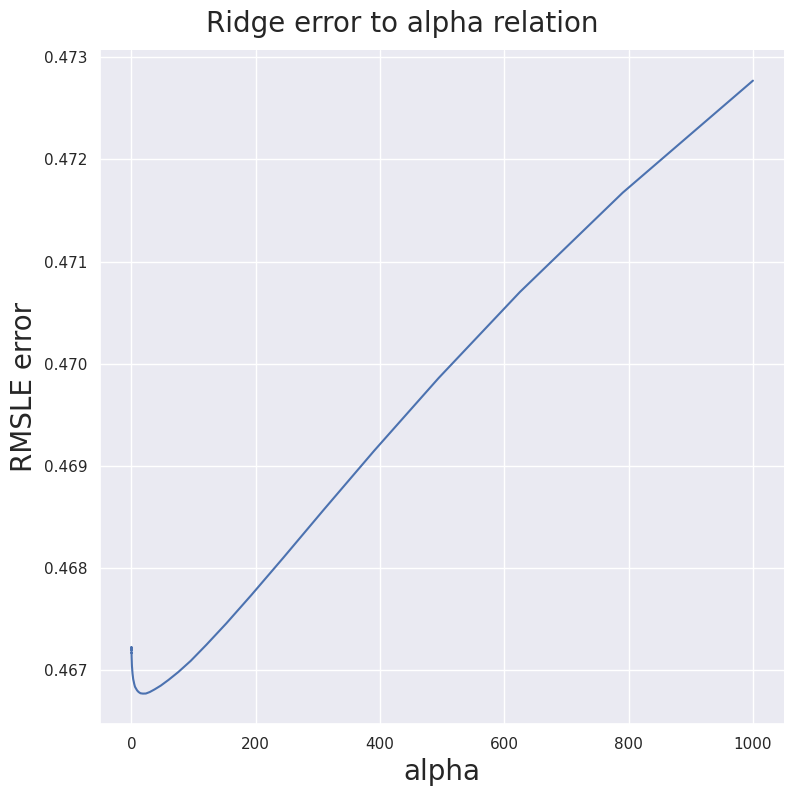

In [68]:
relation = sns.relplot(data=pd.DataFrame({'a': a, 'r': r}), x='a', y='r', kind='line', height=8)
relation.fig.suptitle('Ridge error to alpha relation', fontsize=20)
relation.fig.subplots_adjust(top=0.93)
relation.set_xlabels("alpha", fontsize=20)
relation.set_ylabels("RMSLE error", fontsize=20)
plt.show()

In [69]:
y = data['log_trip_duration']
X = data[['hour',
          'weekday',
          'month',
          'day_num',
          'is_critical_23',
          'is_critical_24',
          'log_haversine',
          'no_traffic',
          'heavy_traffic',
          'is_la_gvardia_airport_start',
          'is_la_gvardia_airport_end',
          'is_kennedi_airport_start',
          'is_kennedi_airport_end',
          'is_newark_airport_start',
          'is_newark_airport_end',
          'pickup_idx',
          'dropoff_idx']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

categorical = ['month',
               'weekday',
               'hour',
               'is_critical_23',
               'is_critical_24',
               'no_traffic',
               'heavy_traffic',
               'is_la_gvardia_airport_start',
               'is_la_gvardia_airport_end',
               'is_kennedi_airport_start',
               'is_kennedi_airport_end',
               'is_newark_airport_start',
               'is_newark_airport_end',
               'pickup_idx',
               'dropoff_idx']
numeric = ['day_num', 'log_haversine']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(alpha=best_ridge_alpha))
])

prediction = pipeline.fit(X_train, y_train).predict(X_test)
print("RMSLE best ridge error:", rmsle(prediction, y_test))

RMSLE best ridge error: 0.46604454095351966


**Теперь разберемся с лассо.**

In [70]:
y = data['log_trip_duration']
X = data[['hour',
          'weekday',
          'month',
          'day_num',
          'is_critical_23',
          'is_critical_24',
          'log_haversine',
          'no_traffic',
          'heavy_traffic',
          'is_la_gvardia_airport_start',
          'is_la_gvardia_airport_end',
          'is_kennedi_airport_start',
          'is_kennedi_airport_end',
          'is_newark_airport_start',
          'is_newark_airport_end',
          'pickup_idx',
          'dropoff_idx']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=4269)

categorical = ['month',
               'weekday',
               'hour',
               'is_critical_23',
               'is_critical_24',
               'no_traffic',
               'heavy_traffic',
               'is_la_gvardia_airport_start',
               'is_la_gvardia_airport_end',
               'is_kennedi_airport_start',
               'is_kennedi_airport_end',
               'is_newark_airport_start',
               'is_newark_airport_end',
               'pickup_idx',
               'dropoff_idx']
numeric = ['day_num', 'log_haversine']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

best_lasso_alpha = 0
best_rmsle = 999999
a = []
r = []
for alpha in np.logspace(-3, 0, 20):
    pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', Lasso(alpha=alpha))
    ])

    prediction = pipeline.fit(X_valid, y_valid).predict(X_test)
    res = rmsle(prediction, y_test)
    if best_rmsle > res:
        best_rmsle = res
        best_lasso_alpha = alpha
    a.append(alpha)
    r.append(res)
print("RMSLE best lasso error is with a=", best_lasso_alpha, "is", best_rmsle)

RMSLE best lasso error is with a= 0.001 is 0.4834244564577837


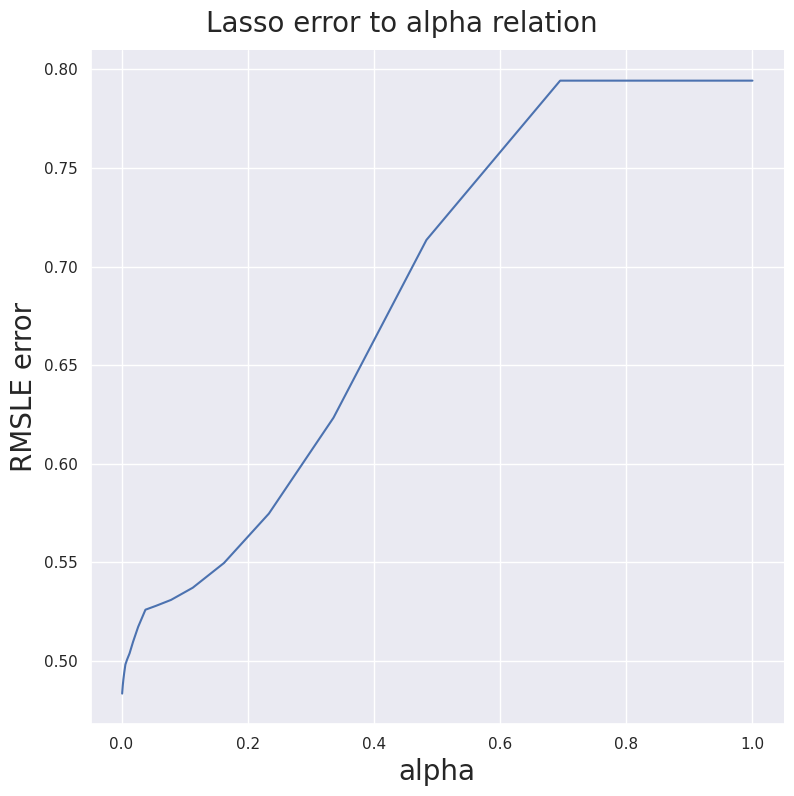

In [71]:
relation = sns.relplot(data=pd.DataFrame({'a': a, 'r': r}), x='a', y='r', kind='line', height=8)
relation.fig.suptitle('Lasso error to alpha relation', fontsize=20)
relation.fig.subplots_adjust(top=0.93)
relation.set_xlabels("alpha", fontsize=20)
relation.set_ylabels("RMSLE error", fontsize=20)
plt.show()

In [72]:
y = data['log_trip_duration']
X = data[['hour',
          'weekday',
          'month',
          'day_num',
          'is_critical_23',
          'is_critical_24',
          'log_haversine',
          'no_traffic',
          'heavy_traffic',
          'is_la_gvardia_airport_start',
          'is_la_gvardia_airport_end',
          'is_kennedi_airport_start',
          'is_kennedi_airport_end',
          'is_newark_airport_start',
          'is_newark_airport_end',
          'pickup_idx',
          'dropoff_idx']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

categorical = ['month',
               'weekday',
               'hour',
               'is_critical_23',
               'is_critical_24',
               'no_traffic',
               'heavy_traffic',
               'is_la_gvardia_airport_start',
               'is_la_gvardia_airport_end',
               'is_kennedi_airport_start',
               'is_kennedi_airport_end',
               'is_newark_airport_start',
               'is_newark_airport_end',
               'pickup_idx',
               'dropoff_idx']
numeric = ['day_num', 'log_haversine']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(alpha=best_lasso_alpha))
])

prediction = pipeline.fit(X_train, y_train).predict(X_test)
print("RMSLE best lasso error:", rmsle(prediction, y_test))

RMSLE best lasso error: 0.48323392218008443


Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [73]:
y = data['log_trip_duration']
X = data[['hour',
          'weekday',
          'month',
          'day_num',
          'is_critical_23',
          'is_critical_24',
          'log_haversine',
          'no_traffic',
          'heavy_traffic',
          'is_la_gvardia_airport_start',
          'is_la_gvardia_airport_end',
          'is_kennedi_airport_start',
          'is_kennedi_airport_end',
          'is_newark_airport_start',
          'is_newark_airport_end',
          'pickup_idx',
          'dropoff_idx']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

categorical = ['month',
               'weekday',
               'hour',
               'is_critical_23',
               'is_critical_24',
               'no_traffic',
               'heavy_traffic',
               'is_la_gvardia_airport_start',
               'is_la_gvardia_airport_end',
               'is_kennedi_airport_start',
               'is_kennedi_airport_end',
               'is_newark_airport_start',
               'is_newark_airport_end',
               'pickup_idx',
               'dropoff_idx']
numeric = ['day_num', 'log_haversine']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

a = []
r = []
for alpha in np.logspace(-3, 0, 20):
    pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', Lasso(alpha=alpha))
    ])

    model = pipeline.fit(X_train, y_train)
    ct = 0
    for coeff in model.named_steps['regression'].coef_:
        if coeff == 0:
            ct += 1

    prediction = model.predict(X_test)
    res = rmsle(prediction, y_test)
    a.append(alpha)
    r.append(ct)
print("RMSLE best lasso error is with a=", best_lasso_alpha, "is", best_rmsle)

RMSLE best lasso error is with a= 0.001 is 0.4834244564577837


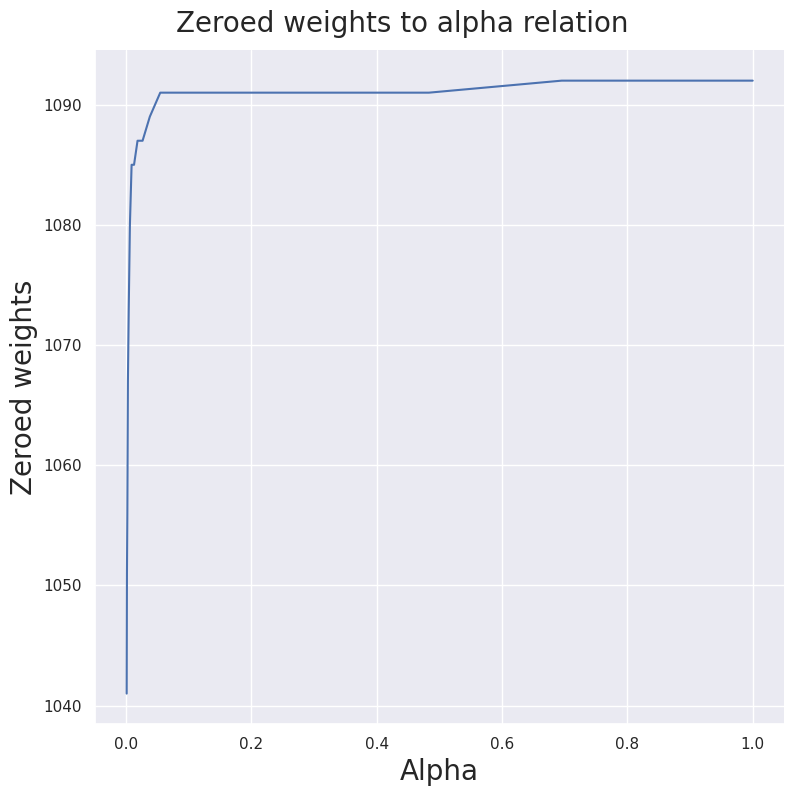

In [74]:
relation = sns.relplot(data=pd.DataFrame({'a': a, 'r': r}), x='a', y='r', kind='line', height=8)
relation.fig.suptitle('Zeroed weights to alpha relation', fontsize=20)
relation.fig.subplots_adjust(top=0.93)
relation.set_xlabels("Alpha", fontsize=20)
relation.set_ylabels("Zeroed weights", fontsize=20)
plt.show()

**По графику нам не нужно ничем жертвовать - при лучшем коэффициенте альфа уже занулены почти все признаки. С другой стороны - у меня не получилось найти самый оптимальный коэффициент, так как он стремится к 0, возможно при меньших значениях будет меньше и количество зануленных признаков.**

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

**Ответ: Допустим, модель может соотнести для одной поездки необходимые коэффициенты. Однако, если мы добавим в выборку новые поездки, то нам придется отслеживать и их влияние на пункты назначения/отправления. Поэтому когда мы вытаскиваем эту информацию в отдельный признак, модель получает большую свободу действий.**

In [75]:
# возьму не 100, а побольше, чтобы кореллировало с количеством блоков в моем разбиении
idx_groups = data.groupby(['pickup_idx', 'dropoff_idx']).size().reset_index()
idx_groups = idx_groups.sort_values(by=[0], ascending=False).head(300).drop(columns=0)
idx_groups['start_end_idx'] = idx_groups.index
data_new = data.merge(idx_groups, how='left', on=['pickup_idx', 'dropoff_idx'])

In [76]:
data_new['start_end_idx'] = data_new['start_end_idx'].fillna(-1)

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [77]:
y = data_new['log_trip_duration']
X = data_new[['hour',
              'weekday',
              'month',
              'day_num',
              'is_critical_23',
              'is_critical_24',
              'log_haversine',
              'no_traffic',
              'heavy_traffic',
              'is_la_gvardia_airport_start',
              'is_la_gvardia_airport_end',
              'is_kennedi_airport_start',
              'is_kennedi_airport_end',
              'is_newark_airport_start',
              'is_newark_airport_end',
              'pickup_idx',
              'dropoff_idx',
              'start_end_idx']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

categorical = ['month',
               'weekday',
               'hour',
               'is_critical_23',
               'is_critical_24',
               'no_traffic',
               'heavy_traffic',
               'is_la_gvardia_airport_start',
               'is_la_gvardia_airport_end',
               'is_kennedi_airport_start',
               'is_kennedi_airport_end',
               'is_newark_airport_start',
               'is_newark_airport_end',
               'pickup_idx',
               'dropoff_idx',
               'start_end_idx']
numeric = ['day_num', 'log_haversine']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(alpha=best_ridge_alpha))
])

prediction = pipeline.fit(X_train, y_train).predict(X_test)
print("RMSLE ridge error:", rmsle(prediction, y_test))

RMSLE ridge error: 0.46410868562841207


**Попробуем добавить еще некоторые признаки и посмотрим, как улучшится (или нет) модель.**

In [78]:
data_new.loc[data_new['pickup_idx'] == data_new['dropoff_idx'], 'same_sq'] = 1
data_new['same_sq'] = data_new['same_sq'].fillna(0)

In [79]:
y = data_new['log_trip_duration']
X = data_new[['hour',
              'weekday',
              'month',
              'day_num',
              'is_critical_23',
              'is_critical_24',
              'log_haversine',
              'no_traffic',
              'heavy_traffic',
              'is_la_gvardia_airport_start',
              'is_la_gvardia_airport_end',
              'is_kennedi_airport_start',
              'is_kennedi_airport_end',
              'is_newark_airport_start',
              'is_newark_airport_end',
              'pickup_idx',
              'dropoff_idx',
              'start_end_idx',
              'same_sq']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

categorical = ['month',
               'weekday',
               'hour',
               'is_critical_23',
               'is_critical_24',
               'no_traffic',
               'heavy_traffic',
               'is_la_gvardia_airport_start',
               'is_la_gvardia_airport_end',
               'is_kennedi_airport_start',
               'is_kennedi_airport_end',
               'is_newark_airport_start',
               'is_newark_airport_end',
               'pickup_idx',
               'dropoff_idx',
               'start_end_idx',
               'same_sq']
numeric = ['day_num', 'log_haversine']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(alpha=best_ridge_alpha))
])

prediction = pipeline.fit(X_train, y_train).predict(X_test)
print("RMSLE ridge error:", rmsle(prediction, y_test))

RMSLE ridge error: 0.46352731298903105


**Ураа, этот признак дал больше, чем учитывание количества пассажиров, вендора и наличия связи с сервером вместе взятых...**

**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут).

In [80]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [81]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [82]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

In [83]:
#